# Policy gradients


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [140]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [141]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [142]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [143]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [144]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [145]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [146]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.846289938887786 -2.6575868403162275
actions: 1 0
rewards: 1.0 1.0


In [147]:
actions[:10]

array([1, 1, 1, 1, 0, 0, 1, 1, 0, 1])

In [148]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [149]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [150]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [151]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [152]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [153]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [154]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [155]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward): # model input
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    #Qs_label = tf.reshape(0.01*targetQs[:-1]) + (0.99*targetQs[1:]), shape=[-1, 1])
    Qs_label = tf.reshape(tf.nn.sigmoid(targetQs[:-1]) + (0.99*targetQs[1:]), shape=[-1, 1])
    g_loss = tf.reduce_mean(neg_log_prob_actions * Qs_label) * reward 
    # reward = episode_total_reward/goal_total_reward --> success/fail rate of episode
    
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states) # Q=sum(rewards)
    Qs_logits += discriminator(actions=tf.nn.softmax(actions_logits), hidden_size=hidden_size, states=states, 
                               reuse=True) # Q=sum(rewards)
    Qs_logits += discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    Qs_logits /= 3
    d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits, 
                                                                    labels=reward*tf.ones_like(Qs_logits)))
    g_loss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits[:-1],
                                                                     labels=tf.nn.sigmoid(Qs_label)))    
    return actions_logits, Qs_logits, g_loss, d_loss

In [156]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [157]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, reward=self.reward, targetQs=self.targetQs) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [158]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [159]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [160]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [161]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [162]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

# Now train with experiences
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(11111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        #for step in (111111111111):
        while True:
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            Q_logits = sess.run(model.Qs_logits, feed_dict={model.states: np.reshape(state, [1, -1]), 
                                                            model.actions: np.array([action])})
            targetQ = Q_logits * (1-float(done))
            batch.append([state, action, targetQ])
            state = next_state
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                #resulting_reward = total_reward/200 # success is 200 points
                resulting_reward = total_reward/500 # success is 500 points
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        #print(targetQs.shape)
        g_loss, d_loss, _, _ = sess.run([model.g_loss, model.d_loss, model.g_opt, model.d_opt], 
                             feed_dict = {model.states: states, 
                                          model.actions: actions,
                                          model.reward: resulting_reward, 
                                          model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode: {}'.format(ep),
              'mean_episodes_total_reward: {:.4f}'.format(np.mean(episodes_total_reward)),
              'g_loss: {:.4f}'.format(g_loss),
              'd_loss: {:.4f}'.format(d_loss))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) == 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode: 0 mean_episodes_total_reward: 112.0000 g_loss: 0.7571 d_loss: 0.6578
Episode: 1 mean_episodes_total_reward: 100.0000 g_loss: 0.7383 d_loss: 0.6286
Episode: 2 mean_episodes_total_reward: 97.3333 g_loss: 0.7103 d_loss: 0.5945
Episode: 3 mean_episodes_total_reward: 98.5000 g_loss: 0.6910 d_loss: 0.5896
Episode: 4 mean_episodes_total_reward: 98.8000 g_loss: 0.6602 d_loss: 0.5742
Episode: 5 mean_episodes_total_reward: 94.0000 g_loss: 0.7289 d_loss: 0.6018
Episode: 6 mean_episodes_total_reward: 98.0000 g_loss: 0.7352 d_loss: 0.6270
Episode: 7 mean_episodes_total_reward: 93.3750 g_loss: 0.7201 d_loss: 0.5733
Episode: 8 mean_episodes_total_reward: 88.1111 g_loss: 0.7152 d_loss: 0.5471
Episode: 9 mean_episodes_total_reward: 82.4000 g_loss: 0.7091 d_loss: 0.5094
Episode: 10 mean_episodes_total_reward: 78.2727 g_loss: 0.7041 d_loss: 0.5046
Episode: 11 mean_episodes_total_reward: 74.4167 g_loss: 0.7013 d_loss: 0.4880
Episode: 12 mean_episodes_total_reward: 70.5385 g_loss: 0.6970 d_loss: 0

Episode: 110 mean_episodes_total_reward: 18.0700 g_loss: 0.1486 d_loss: 0.2124
Episode: 111 mean_episodes_total_reward: 17.9400 g_loss: 0.2011 d_loss: 0.1628
Episode: 112 mean_episodes_total_reward: 17.9400 g_loss: 0.1707 d_loss: 0.1933
Episode: 113 mean_episodes_total_reward: 17.8700 g_loss: 0.2315 d_loss: 0.1303
Episode: 114 mean_episodes_total_reward: 17.8700 g_loss: 0.2101 d_loss: 0.1433
Episode: 115 mean_episodes_total_reward: 17.8700 g_loss: 0.2271 d_loss: 0.1374
Episode: 116 mean_episodes_total_reward: 17.8300 g_loss: 0.3271 d_loss: 0.0979
Episode: 117 mean_episodes_total_reward: 17.7700 g_loss: 0.3582 d_loss: 0.0975
Episode: 118 mean_episodes_total_reward: 17.7700 g_loss: 0.2784 d_loss: 0.1101
Episode: 119 mean_episodes_total_reward: 17.7500 g_loss: 0.3845 d_loss: 0.0963
Episode: 120 mean_episodes_total_reward: 17.7500 g_loss: 0.3762 d_loss: 0.0973
Episode: 121 mean_episodes_total_reward: 17.7700 g_loss: 0.3014 d_loss: 0.1110
Episode: 122 mean_episodes_total_reward: 17.7900 g_l

Episode: 218 mean_episodes_total_reward: 19.6200 g_loss: 0.2842 d_loss: 0.1109
Episode: 219 mean_episodes_total_reward: 19.6300 g_loss: 0.3528 d_loss: 0.1068
Episode: 220 mean_episodes_total_reward: 19.6900 g_loss: 0.2320 d_loss: 0.1376
Episode: 221 mean_episodes_total_reward: 19.6700 g_loss: 0.3760 d_loss: 0.0989
Episode: 222 mean_episodes_total_reward: 19.6400 g_loss: 0.3766 d_loss: 0.0990
Episode: 223 mean_episodes_total_reward: 19.4100 g_loss: 0.1935 d_loss: 0.1752
Episode: 224 mean_episodes_total_reward: 19.1800 g_loss: 0.2182 d_loss: 0.1506
Episode: 225 mean_episodes_total_reward: 19.1200 g_loss: 0.1678 d_loss: 0.1872
Episode: 226 mean_episodes_total_reward: 18.9100 g_loss: 0.2951 d_loss: 0.1116
Episode: 227 mean_episodes_total_reward: 18.8400 g_loss: 0.2175 d_loss: 0.1365
Episode: 228 mean_episodes_total_reward: 18.8400 g_loss: 0.2299 d_loss: 0.1368
Episode: 229 mean_episodes_total_reward: 18.7800 g_loss: 0.3427 d_loss: 0.0958
Episode: 230 mean_episodes_total_reward: 18.7600 g_l

Episode: 322 mean_episodes_total_reward: 20.3500 g_loss: 0.3212 d_loss: 0.1056
Episode: 323 mean_episodes_total_reward: 20.2400 g_loss: 0.3481 d_loss: 0.1065
Episode: 324 mean_episodes_total_reward: 20.1700 g_loss: 0.3190 d_loss: 0.1052
Episode: 325 mean_episodes_total_reward: 20.0400 g_loss: 0.3141 d_loss: 0.1056
Episode: 326 mean_episodes_total_reward: 20.0700 g_loss: 0.2458 d_loss: 0.1317
Episode: 327 mean_episodes_total_reward: 20.0800 g_loss: 0.2250 d_loss: 0.1442
Episode: 328 mean_episodes_total_reward: 20.1400 g_loss: 0.2024 d_loss: 0.1754
Episode: 329 mean_episodes_total_reward: 20.2500 g_loss: 0.2103 d_loss: 0.1697
Episode: 330 mean_episodes_total_reward: 20.2400 g_loss: 0.3119 d_loss: 0.1037
Episode: 331 mean_episodes_total_reward: 20.3500 g_loss: 0.1899 d_loss: 0.1820
Episode: 332 mean_episodes_total_reward: 19.9100 g_loss: 0.0706 d_loss: 0.3001
Episode: 333 mean_episodes_total_reward: 19.3200 g_loss: 0.2700 d_loss: 0.1246
Episode: 334 mean_episodes_total_reward: 20.7400 g_l

Episode: 427 mean_episodes_total_reward: 23.7200 g_loss: 0.0023 d_loss: 0.3854
Episode: 428 mean_episodes_total_reward: 24.0300 g_loss: 0.0159 d_loss: 0.3626
Episode: 429 mean_episodes_total_reward: 23.9300 g_loss: 0.3168 d_loss: 0.1014
Episode: 430 mean_episodes_total_reward: 23.9200 g_loss: 0.3652 d_loss: 0.0956
Episode: 431 mean_episodes_total_reward: 23.8200 g_loss: 0.2562 d_loss: 0.1168
Episode: 432 mean_episodes_total_reward: 23.5500 g_loss: 0.2365 d_loss: 0.1291
Episode: 433 mean_episodes_total_reward: 23.5100 g_loss: 0.3709 d_loss: 0.0964
Episode: 434 mean_episodes_total_reward: 22.0400 g_loss: 0.3675 d_loss: 0.0951
Episode: 435 mean_episodes_total_reward: 22.2300 g_loss: 0.1122 d_loss: 0.2312
Episode: 436 mean_episodes_total_reward: 23.1800 g_loss: -0.1959 d_loss: 0.6782
Episode: 437 mean_episodes_total_reward: 23.6000 g_loss: 0.0176 d_loss: 0.3723
Episode: 438 mean_episodes_total_reward: 23.7500 g_loss: 0.1369 d_loss: 0.2179
Episode: 439 mean_episodes_total_reward: 23.7900 g_

Episode: 535 mean_episodes_total_reward: 19.7400 g_loss: 0.1714 d_loss: 0.1501
Episode: 536 mean_episodes_total_reward: 18.8400 g_loss: 0.1760 d_loss: 0.1430
Episode: 537 mean_episodes_total_reward: 18.4600 g_loss: 0.1765 d_loss: 0.1430
Episode: 538 mean_episodes_total_reward: 18.3300 g_loss: 0.1776 d_loss: 0.1372
Episode: 539 mean_episodes_total_reward: 18.2400 g_loss: 0.2501 d_loss: 0.1077
Episode: 540 mean_episodes_total_reward: 18.2100 g_loss: 0.2369 d_loss: 0.1150
Episode: 541 mean_episodes_total_reward: 18.1700 g_loss: 0.2907 d_loss: 0.1000
Episode: 542 mean_episodes_total_reward: 18.1800 g_loss: 0.2391 d_loss: 0.1148
Episode: 543 mean_episodes_total_reward: 18.2500 g_loss: 0.1938 d_loss: 0.1432
Episode: 544 mean_episodes_total_reward: 18.7700 g_loss: -0.0367 d_loss: 0.4234
Episode: 545 mean_episodes_total_reward: 19.4100 g_loss: -0.1143 d_loss: 0.5216
Episode: 546 mean_episodes_total_reward: 20.3000 g_loss: -0.1718 d_loss: 0.6422
Episode: 547 mean_episodes_total_reward: 20.8700 

Episode: 646 mean_episodes_total_reward: 17.6100 g_loss: 0.3424 d_loss: 0.1059
Episode: 647 mean_episodes_total_reward: 17.1200 g_loss: 0.1997 d_loss: 0.1558
Episode: 648 mean_episodes_total_reward: 16.9800 g_loss: 0.1877 d_loss: 0.1621
Episode: 649 mean_episodes_total_reward: 16.9200 g_loss: 0.1725 d_loss: 0.1685
Episode: 650 mean_episodes_total_reward: 16.8300 g_loss: 0.2509 d_loss: 0.1229
Episode: 651 mean_episodes_total_reward: 16.7500 g_loss: 0.2211 d_loss: 0.1289
Episode: 652 mean_episodes_total_reward: 16.6800 g_loss: 0.2522 d_loss: 0.1156
Episode: 653 mean_episodes_total_reward: 16.6900 g_loss: 0.2398 d_loss: 0.1220
Episode: 654 mean_episodes_total_reward: 16.7400 g_loss: 0.1707 d_loss: 0.1624
Episode: 655 mean_episodes_total_reward: 16.7600 g_loss: 0.2401 d_loss: 0.1221
Episode: 656 mean_episodes_total_reward: 16.8500 g_loss: 0.1730 d_loss: 0.1557
Episode: 657 mean_episodes_total_reward: 16.9800 g_loss: 0.1277 d_loss: 0.1891
Episode: 658 mean_episodes_total_reward: 17.0300 g_l

Episode: 761 mean_episodes_total_reward: 21.2100 g_loss: 0.3413 d_loss: 0.1054
Episode: 762 mean_episodes_total_reward: 20.9500 g_loss: 0.3669 d_loss: 0.0982
Episode: 763 mean_episodes_total_reward: 20.3000 g_loss: 0.1131 d_loss: 0.2301
Episode: 764 mean_episodes_total_reward: 20.0200 g_loss: 0.1729 d_loss: 0.1625
Episode: 765 mean_episodes_total_reward: 19.6700 g_loss: 0.1875 d_loss: 0.1493
Episode: 766 mean_episodes_total_reward: 19.3900 g_loss: 0.2455 d_loss: 0.1155
Episode: 767 mean_episodes_total_reward: 19.2400 g_loss: 0.2973 d_loss: 0.1012
Episode: 768 mean_episodes_total_reward: 19.1900 g_loss: 0.2492 d_loss: 0.1152
Episode: 769 mean_episodes_total_reward: 19.1400 g_loss: 0.2205 d_loss: 0.1223
Episode: 770 mean_episodes_total_reward: 19.1100 g_loss: 0.2590 d_loss: 0.1082
Episode: 771 mean_episodes_total_reward: 19.0700 g_loss: 0.2094 d_loss: 0.1293
Episode: 772 mean_episodes_total_reward: 19.0300 g_loss: 0.2641 d_loss: 0.1082
Episode: 773 mean_episodes_total_reward: 19.0900 g_l

Episode: 869 mean_episodes_total_reward: 21.7200 g_loss: 0.3225 d_loss: 0.1187
Episode: 870 mean_episodes_total_reward: 21.7100 g_loss: 0.3251 d_loss: 0.1113
Episode: 871 mean_episodes_total_reward: 21.6800 g_loss: 0.3009 d_loss: 0.1164
Episode: 872 mean_episodes_total_reward: 21.6900 g_loss: 0.3201 d_loss: 0.1265
Episode: 873 mean_episodes_total_reward: 21.7500 g_loss: 0.2272 d_loss: 0.1959
Episode: 874 mean_episodes_total_reward: 21.9000 g_loss: 0.2131 d_loss: 0.2358
Episode: 875 mean_episodes_total_reward: 22.0000 g_loss: 0.2409 d_loss: 0.1979
Episode: 876 mean_episodes_total_reward: 22.1200 g_loss: 0.2476 d_loss: 0.2046
Episode: 877 mean_episodes_total_reward: 22.1700 g_loss: 0.2113 d_loss: 0.2407
Episode: 878 mean_episodes_total_reward: 22.2500 g_loss: 0.2109 d_loss: 0.2248
Episode: 879 mean_episodes_total_reward: 22.2800 g_loss: 0.1861 d_loss: 0.2619
Episode: 880 mean_episodes_total_reward: 23.2200 g_loss: -0.1701 d_loss: 0.7210
Episode: 881 mean_episodes_total_reward: 22.9900 g_

Episode: 976 mean_episodes_total_reward: 27.5600 g_loss: -0.1593 d_loss: 0.6266
Episode: 977 mean_episodes_total_reward: 27.9500 g_loss: -0.0822 d_loss: 0.4849
Episode: 978 mean_episodes_total_reward: 28.0600 g_loss: 0.0916 d_loss: 0.2868
Episode: 979 mean_episodes_total_reward: 27.8900 g_loss: 0.2134 d_loss: 0.1631
Episode: 980 mean_episodes_total_reward: 26.9100 g_loss: 0.1824 d_loss: 0.1870
Episode: 981 mean_episodes_total_reward: 26.9700 g_loss: 0.2226 d_loss: 0.1509
Episode: 982 mean_episodes_total_reward: 26.9900 g_loss: 0.2723 d_loss: 0.1269
Episode: 983 mean_episodes_total_reward: 26.6900 g_loss: 0.2596 d_loss: 0.1256
Episode: 984 mean_episodes_total_reward: 26.6900 g_loss: 0.3443 d_loss: 0.0994
Episode: 985 mean_episodes_total_reward: 26.7100 g_loss: 0.2675 d_loss: 0.1182
Episode: 986 mean_episodes_total_reward: 26.7300 g_loss: 0.2942 d_loss: 0.1127
Episode: 987 mean_episodes_total_reward: 26.3000 g_loss: 0.2695 d_loss: 0.1187
Episode: 988 mean_episodes_total_reward: 25.6500 g

Episode: 1080 mean_episodes_total_reward: 22.2700 g_loss: 0.2278 d_loss: 0.1648
Episode: 1081 mean_episodes_total_reward: 22.2800 g_loss: 0.2348 d_loss: 0.1585
Episode: 1082 mean_episodes_total_reward: 22.2900 g_loss: 0.2626 d_loss: 0.1344
Episode: 1083 mean_episodes_total_reward: 22.2700 g_loss: 0.2954 d_loss: 0.1135
Episode: 1084 mean_episodes_total_reward: 22.3100 g_loss: 0.2632 d_loss: 0.1262
Episode: 1085 mean_episodes_total_reward: 22.3000 g_loss: 0.2980 d_loss: 0.1131
Episode: 1086 mean_episodes_total_reward: 22.3000 g_loss: 0.3003 d_loss: 0.1136
Episode: 1087 mean_episodes_total_reward: 22.3000 g_loss: 0.2686 d_loss: 0.1187
Episode: 1088 mean_episodes_total_reward: 22.2700 g_loss: 0.3205 d_loss: 0.1147
Episode: 1089 mean_episodes_total_reward: 22.3000 g_loss: 0.2709 d_loss: 0.1192
Episode: 1090 mean_episodes_total_reward: 22.2800 g_loss: 0.4077 d_loss: 0.0967
Episode: 1091 mean_episodes_total_reward: 22.2100 g_loss: 0.3334 d_loss: 0.1077
Episode: 1092 mean_episodes_total_reward

Episode: 1183 mean_episodes_total_reward: 20.9100 g_loss: 0.2039 d_loss: 0.2354
Episode: 1184 mean_episodes_total_reward: 21.0900 g_loss: 0.2151 d_loss: 0.2349
Episode: 1185 mean_episodes_total_reward: 21.1400 g_loss: 0.2566 d_loss: 0.1495
Episode: 1186 mean_episodes_total_reward: 21.2300 g_loss: 0.2350 d_loss: 0.1724
Episode: 1187 mean_episodes_total_reward: 21.2100 g_loss: 0.3002 d_loss: 0.1042
Episode: 1188 mean_episodes_total_reward: 21.2200 g_loss: 0.2428 d_loss: 0.1174
Episode: 1189 mean_episodes_total_reward: 21.3200 g_loss: 0.2183 d_loss: 0.1829
Episode: 1190 mean_episodes_total_reward: 21.6000 g_loss: 0.1666 d_loss: 0.2633
Episode: 1191 mean_episodes_total_reward: 22.0000 g_loss: 0.1232 d_loss: 0.3387
Episode: 1192 mean_episodes_total_reward: 22.4400 g_loss: 0.1240 d_loss: 0.3502
Episode: 1193 mean_episodes_total_reward: 22.6300 g_loss: 0.2252 d_loss: 0.2288
Episode: 1194 mean_episodes_total_reward: 22.7500 g_loss: 0.2618 d_loss: 0.1936
Episode: 1195 mean_episodes_total_reward

Episode: 1286 mean_episodes_total_reward: 26.3200 g_loss: 0.1018 d_loss: 0.2627
Episode: 1287 mean_episodes_total_reward: 26.6200 g_loss: 0.0648 d_loss: 0.2939
Episode: 1288 mean_episodes_total_reward: 26.7200 g_loss: 0.1641 d_loss: 0.1823
Episode: 1289 mean_episodes_total_reward: 26.6100 g_loss: 0.2722 d_loss: 0.1102
Episode: 1290 mean_episodes_total_reward: 26.3300 g_loss: 0.4054 d_loss: 0.0900
Episode: 1291 mean_episodes_total_reward: 25.9500 g_loss: 0.2672 d_loss: 0.1186
Episode: 1292 mean_episodes_total_reward: 25.5100 g_loss: 0.3040 d_loss: 0.1039
Episode: 1293 mean_episodes_total_reward: 25.3000 g_loss: 0.3692 d_loss: 0.1024
Episode: 1294 mean_episodes_total_reward: 25.1700 g_loss: 0.3489 d_loss: 0.1095
Episode: 1295 mean_episodes_total_reward: 25.0600 g_loss: 0.2051 d_loss: 0.2273
Episode: 1296 mean_episodes_total_reward: 25.0100 g_loss: 0.2366 d_loss: 0.1385
Episode: 1297 mean_episodes_total_reward: 25.0000 g_loss: 0.2284 d_loss: 0.1450
Episode: 1298 mean_episodes_total_reward

Episode: 1392 mean_episodes_total_reward: 21.7900 g_loss: 0.0671 d_loss: 0.2664
Episode: 1393 mean_episodes_total_reward: 21.8200 g_loss: 0.2427 d_loss: 0.1148
Episode: 1394 mean_episodes_total_reward: 21.8800 g_loss: 0.2168 d_loss: 0.1431
Episode: 1395 mean_episodes_total_reward: 21.9800 g_loss: 0.0688 d_loss: 0.2926
Episode: 1396 mean_episodes_total_reward: 22.5000 g_loss: -0.0603 d_loss: 0.4631
Episode: 1397 mean_episodes_total_reward: 22.7100 g_loss: 0.0970 d_loss: 0.2757
Episode: 1398 mean_episodes_total_reward: 22.9400 g_loss: 0.0792 d_loss: 0.2788
Episode: 1399 mean_episodes_total_reward: 23.3100 g_loss: 0.0292 d_loss: 0.3450
Episode: 1400 mean_episodes_total_reward: 23.3700 g_loss: 0.2053 d_loss: 0.1513
Episode: 1401 mean_episodes_total_reward: 23.3100 g_loss: 0.3380 d_loss: 0.0971
Episode: 1402 mean_episodes_total_reward: 23.2600 g_loss: 0.3379 d_loss: 0.0973
Episode: 1403 mean_episodes_total_reward: 23.3700 g_loss: 0.1700 d_loss: 0.1944
Episode: 1404 mean_episodes_total_rewar

Episode: 1500 mean_episodes_total_reward: 27.8300 g_loss: 0.2094 d_loss: 0.1298
Episode: 1501 mean_episodes_total_reward: 27.8700 g_loss: 0.2195 d_loss: 0.1228
Episode: 1502 mean_episodes_total_reward: 28.1500 g_loss: 0.1730 d_loss: 0.2666
Episode: 1503 mean_episodes_total_reward: 32.9100 g_loss: -1.7763 d_loss: 3.0089
Episode: 1504 mean_episodes_total_reward: 32.9900 g_loss: 0.1768 d_loss: 0.2107
Episode: 1505 mean_episodes_total_reward: 32.3500 g_loss: 0.3171 d_loss: 0.1055
Episode: 1506 mean_episodes_total_reward: 32.2100 g_loss: 0.3087 d_loss: 0.1157
Episode: 1507 mean_episodes_total_reward: 31.9600 g_loss: 0.3201 d_loss: 0.1172
Episode: 1508 mean_episodes_total_reward: 31.8100 g_loss: 0.3288 d_loss: 0.1211
Episode: 1509 mean_episodes_total_reward: 31.8000 g_loss: 0.3270 d_loss: 0.1210
Episode: 1510 mean_episodes_total_reward: 31.7800 g_loss: 0.3666 d_loss: 0.1121
Episode: 1511 mean_episodes_total_reward: 31.7600 g_loss: 0.3691 d_loss: 0.1133
Episode: 1512 mean_episodes_total_rewar

Episode: 1604 mean_episodes_total_reward: 22.1000 g_loss: 0.0441 d_loss: 0.2796
Episode: 1605 mean_episodes_total_reward: 22.3800 g_loss: 0.0345 d_loss: 0.2931
Episode: 1606 mean_episodes_total_reward: 22.3700 g_loss: 0.2867 d_loss: 0.1045
Episode: 1607 mean_episodes_total_reward: 22.3600 g_loss: 0.2883 d_loss: 0.1042
Episode: 1608 mean_episodes_total_reward: 22.5200 g_loss: 0.0883 d_loss: 0.2232
Episode: 1609 mean_episodes_total_reward: 22.6500 g_loss: 0.1158 d_loss: 0.2026
Episode: 1610 mean_episodes_total_reward: 22.6800 g_loss: 0.1923 d_loss: 0.1237
Episode: 1611 mean_episodes_total_reward: 22.6800 g_loss: 0.2614 d_loss: 0.1020
Episode: 1612 mean_episodes_total_reward: 22.7000 g_loss: 0.2376 d_loss: 0.1090
Episode: 1613 mean_episodes_total_reward: 22.6400 g_loss: 0.2765 d_loss: 0.1107
Episode: 1614 mean_episodes_total_reward: 22.7400 g_loss: 0.1695 d_loss: 0.1804
Episode: 1615 mean_episodes_total_reward: 22.7400 g_loss: 0.2231 d_loss: 0.1180
Episode: 1616 mean_episodes_total_reward

Episode: 1711 mean_episodes_total_reward: 25.7900 g_loss: 0.2010 d_loss: 0.1818
Episode: 1712 mean_episodes_total_reward: 25.8800 g_loss: 0.2324 d_loss: 0.1724
Episode: 1713 mean_episodes_total_reward: 26.1400 g_loss: 0.1024 d_loss: 0.2829
Episode: 1714 mean_episodes_total_reward: 26.2700 g_loss: 0.1125 d_loss: 0.2630
Episode: 1715 mean_episodes_total_reward: 26.6400 g_loss: 0.0395 d_loss: 0.3480
Episode: 1716 mean_episodes_total_reward: 26.6800 g_loss: 0.2477 d_loss: 0.1319
Episode: 1717 mean_episodes_total_reward: 26.6600 g_loss: 0.2037 d_loss: 0.1361
Episode: 1718 mean_episodes_total_reward: 26.5900 g_loss: 0.2639 d_loss: 0.1095
Episode: 1719 mean_episodes_total_reward: 26.5700 g_loss: 0.2453 d_loss: 0.1162
Episode: 1720 mean_episodes_total_reward: 26.5400 g_loss: 0.2206 d_loss: 0.1229
Episode: 1721 mean_episodes_total_reward: 26.5200 g_loss: 0.2571 d_loss: 0.1088
Episode: 1722 mean_episodes_total_reward: 26.4500 g_loss: 0.1919 d_loss: 0.1492
Episode: 1723 mean_episodes_total_reward

Episode: 1815 mean_episodes_total_reward: 26.6500 g_loss: 0.2388 d_loss: 0.2571
Episode: 1816 mean_episodes_total_reward: 27.1500 g_loss: 0.1475 d_loss: 0.3935
Episode: 1817 mean_episodes_total_reward: 28.9400 g_loss: -0.2560 d_loss: 0.9939
Episode: 1818 mean_episodes_total_reward: 29.4600 g_loss: 0.2025 d_loss: 0.3833
Episode: 1819 mean_episodes_total_reward: 30.3300 g_loss: 0.0470 d_loss: 0.5521
Episode: 1820 mean_episodes_total_reward: 30.8700 g_loss: 0.1529 d_loss: 0.4047
Episode: 1821 mean_episodes_total_reward: 31.2600 g_loss: 0.2508 d_loss: 0.3303
Episode: 1822 mean_episodes_total_reward: 31.2800 g_loss: 0.2893 d_loss: 0.1760
Episode: 1823 mean_episodes_total_reward: 31.2200 g_loss: 0.2933 d_loss: 0.1562
Episode: 1824 mean_episodes_total_reward: 31.2500 g_loss: 0.2736 d_loss: 0.1523
Episode: 1825 mean_episodes_total_reward: 31.2900 g_loss: 0.2826 d_loss: 0.1474
Episode: 1826 mean_episodes_total_reward: 31.3300 g_loss: 0.2995 d_loss: 0.1415
Episode: 1827 mean_episodes_total_rewar

Episode: 1920 mean_episodes_total_reward: 21.2700 g_loss: 0.1981 d_loss: 0.1844
Episode: 1921 mean_episodes_total_reward: 21.0100 g_loss: 0.1973 d_loss: 0.1963
Episode: 1922 mean_episodes_total_reward: 21.2900 g_loss: 0.1151 d_loss: 0.3221
Episode: 1923 mean_episodes_total_reward: 21.5200 g_loss: 0.1343 d_loss: 0.2767
Episode: 1924 mean_episodes_total_reward: 21.5300 g_loss: 0.2026 d_loss: 0.1496
Episode: 1925 mean_episodes_total_reward: 21.4900 g_loss: 0.2742 d_loss: 0.1096
Episode: 1926 mean_episodes_total_reward: 21.4900 g_loss: 0.2026 d_loss: 0.1301
Episode: 1927 mean_episodes_total_reward: 21.5300 g_loss: 0.2087 d_loss: 0.1435
Episode: 1928 mean_episodes_total_reward: 22.2100 g_loss: -0.0954 d_loss: 0.5314
Episode: 1929 mean_episodes_total_reward: 23.0400 g_loss: -0.1670 d_loss: 0.6260
Episode: 1930 mean_episodes_total_reward: 23.2600 g_loss: 0.1360 d_loss: 0.2388
Episode: 1931 mean_episodes_total_reward: 23.2600 g_loss: 0.3208 d_loss: 0.1050
Episode: 1932 mean_episodes_total_rewa

Episode: 2025 mean_episodes_total_reward: 23.7700 g_loss: 0.1668 d_loss: 0.2439
Episode: 2026 mean_episodes_total_reward: 23.8800 g_loss: 0.2000 d_loss: 0.1993
Episode: 2027 mean_episodes_total_reward: 23.9200 g_loss: 0.2230 d_loss: 0.1705
Episode: 2028 mean_episodes_total_reward: 23.3400 g_loss: 0.1933 d_loss: 0.1819
Episode: 2029 mean_episodes_total_reward: 22.6300 g_loss: 0.1779 d_loss: 0.1938
Episode: 2030 mean_episodes_total_reward: 22.4800 g_loss: 0.1984 d_loss: 0.1446
Episode: 2031 mean_episodes_total_reward: 22.4700 g_loss: 0.3288 d_loss: 0.0951
Episode: 2032 mean_episodes_total_reward: 22.6500 g_loss: 0.1978 d_loss: 0.2311
Episode: 2033 mean_episodes_total_reward: 22.4500 g_loss: 0.3737 d_loss: 0.0873
Episode: 2034 mean_episodes_total_reward: 22.4200 g_loss: 0.3979 d_loss: 0.0883
Episode: 2035 mean_episodes_total_reward: 22.7100 g_loss: 0.0667 d_loss: 0.3581
Episode: 2036 mean_episodes_total_reward: 22.7100 g_loss: 0.2153 d_loss: 0.1438
Episode: 2037 mean_episodes_total_reward

Episode: 2128 mean_episodes_total_reward: 23.8500 g_loss: 0.2270 d_loss: 0.1368
Episode: 2129 mean_episodes_total_reward: 23.7100 g_loss: 0.3055 d_loss: 0.1036
Episode: 2130 mean_episodes_total_reward: 23.6500 g_loss: 0.3057 d_loss: 0.1037
Episode: 2131 mean_episodes_total_reward: 23.7300 g_loss: 0.2091 d_loss: 0.1497
Episode: 2132 mean_episodes_total_reward: 23.6500 g_loss: 0.1892 d_loss: 0.1750
Episode: 2133 mean_episodes_total_reward: 23.7200 g_loss: 0.2229 d_loss: 0.1373
Episode: 2134 mean_episodes_total_reward: 24.2800 g_loss: 0.1200 d_loss: 0.4021
Episode: 2135 mean_episodes_total_reward: 24.2200 g_loss: 0.1337 d_loss: 0.3134
Episode: 2136 mean_episodes_total_reward: 24.4700 g_loss: 0.1384 d_loss: 0.2946
Episode: 2137 mean_episodes_total_reward: 24.4700 g_loss: 0.2232 d_loss: 0.1298
Episode: 2138 mean_episodes_total_reward: 24.4200 g_loss: 0.3013 d_loss: 0.1018
Episode: 2139 mean_episodes_total_reward: 24.3800 g_loss: 0.2634 d_loss: 0.1084
Episode: 2140 mean_episodes_total_reward

Episode: 2231 mean_episodes_total_reward: 29.9400 g_loss: 0.2905 d_loss: 0.2206
Episode: 2232 mean_episodes_total_reward: 30.0700 g_loss: 0.2941 d_loss: 0.2604
Episode: 2233 mean_episodes_total_reward: 30.2500 g_loss: 0.3241 d_loss: 0.2596
Episode: 2234 mean_episodes_total_reward: 29.9300 g_loss: 0.2520 d_loss: 0.2439
Episode: 2235 mean_episodes_total_reward: 29.7000 g_loss: 0.2420 d_loss: 0.1864
Episode: 2236 mean_episodes_total_reward: 29.4800 g_loss: 0.2154 d_loss: 0.1650
Episode: 2237 mean_episodes_total_reward: 29.4700 g_loss: 0.2532 d_loss: 0.1260
Episode: 2238 mean_episodes_total_reward: 29.4900 g_loss: 0.2673 d_loss: 0.1193
Episode: 2239 mean_episodes_total_reward: 29.8300 g_loss: 0.1356 d_loss: 0.3112
Episode: 2240 mean_episodes_total_reward: 29.9100 g_loss: 0.2484 d_loss: 0.1919
Episode: 2241 mean_episodes_total_reward: 29.9700 g_loss: 0.2845 d_loss: 0.1450
Episode: 2242 mean_episodes_total_reward: 29.9500 g_loss: 0.2885 d_loss: 0.1313
Episode: 2243 mean_episodes_total_reward

Episode: 2340 mean_episodes_total_reward: 20.7500 g_loss: 0.1722 d_loss: 0.1436
Episode: 2341 mean_episodes_total_reward: 20.7400 g_loss: 0.1974 d_loss: 0.1295
Episode: 2342 mean_episodes_total_reward: 20.7400 g_loss: 0.2191 d_loss: 0.1221
Episode: 2343 mean_episodes_total_reward: 20.8100 g_loss: 0.1744 d_loss: 0.1621
Episode: 2344 mean_episodes_total_reward: 25.6600 g_loss: -1.6043 d_loss: 2.8205
Episode: 2345 mean_episodes_total_reward: 25.6800 g_loss: 0.2049 d_loss: 0.1374
Episode: 2346 mean_episodes_total_reward: 25.6500 g_loss: 0.3514 d_loss: 0.0974
Episode: 2347 mean_episodes_total_reward: 25.6100 g_loss: 0.3092 d_loss: 0.1137
Episode: 2348 mean_episodes_total_reward: 25.3500 g_loss: 0.3552 d_loss: 0.1000
Episode: 2349 mean_episodes_total_reward: 25.2500 g_loss: 0.3273 d_loss: 0.1071
Episode: 2350 mean_episodes_total_reward: 25.1700 g_loss: 0.4131 d_loss: 0.0969
Episode: 2351 mean_episodes_total_reward: 25.1100 g_loss: 0.3705 d_loss: 0.1048
Episode: 2352 mean_episodes_total_rewar

Episode: 2448 mean_episodes_total_reward: 22.8400 g_loss: 0.2419 d_loss: 0.1234
Episode: 2449 mean_episodes_total_reward: 22.8400 g_loss: 0.2764 d_loss: 0.1022
Episode: 2450 mean_episodes_total_reward: 22.8600 g_loss: 0.2920 d_loss: 0.1026
Episode: 2451 mean_episodes_total_reward: 22.9800 g_loss: 0.1663 d_loss: 0.1801
Episode: 2452 mean_episodes_total_reward: 23.0100 g_loss: 0.2452 d_loss: 0.1175
Episode: 2453 mean_episodes_total_reward: 23.3400 g_loss: 0.0178 d_loss: 0.3451
Episode: 2454 mean_episodes_total_reward: 22.9000 g_loss: 0.2222 d_loss: 0.1235
Episode: 2455 mean_episodes_total_reward: 22.7100 g_loss: 0.0954 d_loss: 0.2426
Episode: 2456 mean_episodes_total_reward: 22.6300 g_loss: 0.3459 d_loss: 0.0954
Episode: 2457 mean_episodes_total_reward: 22.6000 g_loss: 0.2565 d_loss: 0.1170
Episode: 2458 mean_episodes_total_reward: 22.9400 g_loss: 0.1421 d_loss: 0.3396
Episode: 2459 mean_episodes_total_reward: 22.6700 g_loss: 0.3429 d_loss: 0.0958
Episode: 2460 mean_episodes_total_reward

Episode: 2554 mean_episodes_total_reward: 23.9200 g_loss: -0.1563 d_loss: 0.7193
Episode: 2555 mean_episodes_total_reward: 24.4000 g_loss: -0.0398 d_loss: 0.5003
Episode: 2556 mean_episodes_total_reward: 24.4600 g_loss: 0.2155 d_loss: 0.1367
Episode: 2557 mean_episodes_total_reward: 24.4500 g_loss: 0.2677 d_loss: 0.1088
Episode: 2558 mean_episodes_total_reward: 24.0400 g_loss: 0.2865 d_loss: 0.1017
Episode: 2559 mean_episodes_total_reward: 24.2700 g_loss: 0.1423 d_loss: 0.2406
Episode: 2560 mean_episodes_total_reward: 26.3000 g_loss: -0.5348 d_loss: 1.2378
Episode: 2561 mean_episodes_total_reward: 26.2600 g_loss: 0.3955 d_loss: 0.0916
Episode: 2562 mean_episodes_total_reward: 26.1000 g_loss: 0.3286 d_loss: 0.1062
Episode: 2563 mean_episodes_total_reward: 25.7300 g_loss: 0.2881 d_loss: 0.1204
Episode: 2564 mean_episodes_total_reward: 25.1600 g_loss: 0.3515 d_loss: 0.1016
Episode: 2565 mean_episodes_total_reward: 25.3500 g_loss: 0.2544 d_loss: 0.3230
Episode: 2566 mean_episodes_total_rew

Episode: 2658 mean_episodes_total_reward: 26.9700 g_loss: 0.1502 d_loss: 0.2618
Episode: 2659 mean_episodes_total_reward: 26.9600 g_loss: 0.2186 d_loss: 0.2347
Episode: 2660 mean_episodes_total_reward: 25.1000 g_loss: 0.2036 d_loss: 0.2111
Episode: 2661 mean_episodes_total_reward: 25.1900 g_loss: 0.2333 d_loss: 0.1527
Episode: 2662 mean_episodes_total_reward: 25.2400 g_loss: 0.2484 d_loss: 0.1396
Episode: 2663 mean_episodes_total_reward: 25.2800 g_loss: 0.2484 d_loss: 0.1459
Episode: 2664 mean_episodes_total_reward: 25.3200 g_loss: 0.2643 d_loss: 0.1256
Episode: 2665 mean_episodes_total_reward: 24.9800 g_loss: 0.2515 d_loss: 0.1316
Episode: 2666 mean_episodes_total_reward: 25.0000 g_loss: 0.2436 d_loss: 0.1384
Episode: 2667 mean_episodes_total_reward: 24.6600 g_loss: 0.2685 d_loss: 0.1190
Episode: 2668 mean_episodes_total_reward: 24.5500 g_loss: 0.1995 d_loss: 0.1878
Episode: 2669 mean_episodes_total_reward: 24.3300 g_loss: 0.3377 d_loss: 0.1053
Episode: 2670 mean_episodes_total_reward

Episode: 2765 mean_episodes_total_reward: 29.7100 g_loss: 0.2408 d_loss: 0.1313
Episode: 2766 mean_episodes_total_reward: 29.7600 g_loss: 0.1926 d_loss: 0.1717
Episode: 2767 mean_episodes_total_reward: 29.7900 g_loss: 0.2403 d_loss: 0.1405
Episode: 2768 mean_episodes_total_reward: 29.8400 g_loss: 0.1233 d_loss: 0.2232
Episode: 2769 mean_episodes_total_reward: 29.8400 g_loss: 0.3074 d_loss: 0.1040
Episode: 2770 mean_episodes_total_reward: 29.8100 g_loss: 0.2433 d_loss: 0.1314
Episode: 2771 mean_episodes_total_reward: 29.8100 g_loss: 0.2529 d_loss: 0.1168
Episode: 2772 mean_episodes_total_reward: 29.9500 g_loss: 0.1510 d_loss: 0.2026
Episode: 2773 mean_episodes_total_reward: 29.9200 g_loss: 0.2515 d_loss: 0.1111
Episode: 2774 mean_episodes_total_reward: 29.9000 g_loss: 0.2478 d_loss: 0.1172
Episode: 2775 mean_episodes_total_reward: 29.8800 g_loss: 0.3019 d_loss: 0.1027
Episode: 2776 mean_episodes_total_reward: 30.2400 g_loss: 0.0851 d_loss: 0.4050
Episode: 2777 mean_episodes_total_reward

Episode: 2868 mean_episodes_total_reward: 40.4300 g_loss: 0.3429 d_loss: 0.1651
Episode: 2869 mean_episodes_total_reward: 40.4500 g_loss: 0.3962 d_loss: 0.1617
Episode: 2870 mean_episodes_total_reward: 45.3100 g_loss: -0.3995 d_loss: 1.7239
Episode: 2871 mean_episodes_total_reward: 48.3300 g_loss: -0.1717 d_loss: 1.2309
Episode: 2872 mean_episodes_total_reward: 48.9500 g_loss: 0.3559 d_loss: 0.4735
Episode: 2873 mean_episodes_total_reward: 48.9800 g_loss: 0.3394 d_loss: 0.1702
Episode: 2874 mean_episodes_total_reward: 48.9600 g_loss: 0.4046 d_loss: 0.1417
Episode: 2875 mean_episodes_total_reward: 48.9700 g_loss: 0.3991 d_loss: 0.1533
Episode: 2876 mean_episodes_total_reward: 48.4700 g_loss: 0.3970 d_loss: 0.1743
Episode: 2877 mean_episodes_total_reward: 48.4800 g_loss: 0.3779 d_loss: 0.1651
Episode: 2878 mean_episodes_total_reward: 48.4400 g_loss: 0.4378 d_loss: 0.1610
Episode: 2879 mean_episodes_total_reward: 48.1600 g_loss: 0.3834 d_loss: 0.1655
Episode: 2880 mean_episodes_total_rewa

Episode: 2979 mean_episodes_total_reward: 28.3400 g_loss: 0.2522 d_loss: 0.1431
Episode: 2980 mean_episodes_total_reward: 28.3600 g_loss: 0.2695 d_loss: 0.1289
Episode: 2981 mean_episodes_total_reward: 28.3900 g_loss: 0.2807 d_loss: 0.1216
Episode: 2982 mean_episodes_total_reward: 28.4000 g_loss: 0.2294 d_loss: 0.1395
Episode: 2983 mean_episodes_total_reward: 29.8800 g_loss: -0.1223 d_loss: 0.8293
Episode: 2984 mean_episodes_total_reward: 30.1100 g_loss: 0.2898 d_loss: 0.2722
Episode: 2985 mean_episodes_total_reward: 30.1400 g_loss: 0.1961 d_loss: 0.1519
Episode: 2986 mean_episodes_total_reward: 29.4500 g_loss: 0.2605 d_loss: 0.1198
Episode: 2987 mean_episodes_total_reward: 27.8600 g_loss: 0.2704 d_loss: 0.1135
Episode: 2988 mean_episodes_total_reward: 27.6000 g_loss: 0.2255 d_loss: 0.1397
Episode: 2989 mean_episodes_total_reward: 27.6000 g_loss: 0.2759 d_loss: 0.3038
Episode: 2990 mean_episodes_total_reward: 28.3600 g_loss: 0.2852 d_loss: 0.4875
Episode: 2991 mean_episodes_total_rewar

Episode: 3083 mean_episodes_total_reward: 33.7300 g_loss: 0.3903 d_loss: 0.4030
Episode: 3084 mean_episodes_total_reward: 33.9500 g_loss: 0.3789 d_loss: 0.3665
Episode: 3085 mean_episodes_total_reward: 34.6100 g_loss: 0.4991 d_loss: 0.5145
Episode: 3086 mean_episodes_total_reward: 34.6600 g_loss: 0.2736 d_loss: 0.1603
Episode: 3087 mean_episodes_total_reward: 34.7100 g_loss: 0.2503 d_loss: 0.1495
Episode: 3088 mean_episodes_total_reward: 34.7200 g_loss: 0.2540 d_loss: 0.1497
Episode: 3089 mean_episodes_total_reward: 34.4700 g_loss: 0.2609 d_loss: 0.1507
Episode: 3090 mean_episodes_total_reward: 33.7800 g_loss: 0.2528 d_loss: 0.1749
Episode: 3091 mean_episodes_total_reward: 31.4200 g_loss: 0.3663 d_loss: 0.3350
Episode: 3092 mean_episodes_total_reward: 33.2900 g_loss: -0.1385 d_loss: 0.9475
Episode: 3093 mean_episodes_total_reward: 33.7800 g_loss: 0.2113 d_loss: 0.3650
Episode: 3094 mean_episodes_total_reward: 33.8200 g_loss: 0.2702 d_loss: 0.1448
Episode: 3095 mean_episodes_total_rewar

Episode: 3189 mean_episodes_total_reward: 30.5400 g_loss: 0.2181 d_loss: 0.1444
Episode: 3190 mean_episodes_total_reward: 30.7500 g_loss: 0.1748 d_loss: 0.2907
Episode: 3191 mean_episodes_total_reward: 30.9500 g_loss: 0.1350 d_loss: 0.4124
Episode: 3192 mean_episodes_total_reward: 29.8100 g_loss: 0.0770 d_loss: 0.5032
Episode: 3193 mean_episodes_total_reward: 29.8300 g_loss: 0.1213 d_loss: 0.3904
Episode: 3194 mean_episodes_total_reward: 29.8100 g_loss: 0.2333 d_loss: 0.1258
Episode: 3195 mean_episodes_total_reward: 29.8000 g_loss: 0.3068 d_loss: 0.1053
Episode: 3196 mean_episodes_total_reward: 30.0300 g_loss: 0.1149 d_loss: 0.2648
Episode: 3197 mean_episodes_total_reward: 30.9800 g_loss: -0.1705 d_loss: 0.7349
Episode: 3198 mean_episodes_total_reward: 31.1900 g_loss: 0.1239 d_loss: 0.2622
Episode: 3199 mean_episodes_total_reward: 31.1400 g_loss: 0.3767 d_loss: 0.1023
Episode: 3200 mean_episodes_total_reward: 31.1200 g_loss: 0.2831 d_loss: 0.1158
Episode: 3201 mean_episodes_total_rewar

Episode: 3292 mean_episodes_total_reward: 33.3500 g_loss: -1.1184 d_loss: 2.3372
Episode: 3293 mean_episodes_total_reward: 32.8300 g_loss: 0.3435 d_loss: 0.1015
Episode: 3294 mean_episodes_total_reward: 32.8100 g_loss: 0.2984 d_loss: 0.1157
Episode: 3295 mean_episodes_total_reward: 32.8100 g_loss: 0.3777 d_loss: 0.1140
Episode: 3296 mean_episodes_total_reward: 32.5600 g_loss: 0.3290 d_loss: 0.1118
Episode: 3297 mean_episodes_total_reward: 31.4300 g_loss: 0.3392 d_loss: 0.1149
Episode: 3298 mean_episodes_total_reward: 31.1800 g_loss: 0.3291 d_loss: 0.1150
Episode: 3299 mean_episodes_total_reward: 31.2500 g_loss: 0.2888 d_loss: 0.1570
Episode: 3300 mean_episodes_total_reward: 32.1400 g_loss: 0.2232 d_loss: 0.5222
Episode: 3301 mean_episodes_total_reward: 32.2200 g_loss: 0.2891 d_loss: 0.1762
Episode: 3302 mean_episodes_total_reward: 32.2700 g_loss: 0.3201 d_loss: 0.1536
Episode: 3303 mean_episodes_total_reward: 32.3500 g_loss: 0.3041 d_loss: 0.1720
Episode: 3304 mean_episodes_total_rewar

Episode: 3399 mean_episodes_total_reward: 42.9400 g_loss: 0.2148 d_loss: 0.2930
Episode: 3400 mean_episodes_total_reward: 42.8300 g_loss: 0.0151 d_loss: 0.5337
Episode: 3401 mean_episodes_total_reward: 47.6400 g_loss: -1.4998 d_loss: 2.7325
Episode: 3402 mean_episodes_total_reward: 47.6000 g_loss: 0.2925 d_loss: 0.1209
Episode: 3403 mean_episodes_total_reward: 47.5300 g_loss: 0.3134 d_loss: 0.1254
Episode: 3404 mean_episodes_total_reward: 47.4500 g_loss: 0.3350 d_loss: 0.1269
Episode: 3405 mean_episodes_total_reward: 47.0500 g_loss: 0.4297 d_loss: 0.1256
Episode: 3406 mean_episodes_total_reward: 46.0300 g_loss: 0.4333 d_loss: 0.1289
Episode: 3407 mean_episodes_total_reward: 44.9900 g_loss: 0.3329 d_loss: 0.1277
Episode: 3408 mean_episodes_total_reward: 44.7800 g_loss: 0.2604 d_loss: 0.2631
Episode: 3409 mean_episodes_total_reward: 44.7000 g_loss: 0.3342 d_loss: 0.1205
Episode: 3410 mean_episodes_total_reward: 44.7600 g_loss: 0.3377 d_loss: 0.2050
Episode: 3411 mean_episodes_total_rewar

Episode: 3502 mean_episodes_total_reward: 34.7800 g_loss: -0.7178 d_loss: 1.7641
Episode: 3503 mean_episodes_total_reward: 35.5000 g_loss: 0.1450 d_loss: 0.4768
Episode: 3504 mean_episodes_total_reward: 35.6700 g_loss: 0.2341 d_loss: 0.2261
Episode: 3505 mean_episodes_total_reward: 35.7000 g_loss: 0.3106 d_loss: 0.1368
Episode: 3506 mean_episodes_total_reward: 35.7300 g_loss: 0.3313 d_loss: 0.1409
Episode: 3507 mean_episodes_total_reward: 35.7700 g_loss: 0.3097 d_loss: 0.1539
Episode: 3508 mean_episodes_total_reward: 35.6400 g_loss: 0.2909 d_loss: 0.1873
Episode: 3509 mean_episodes_total_reward: 35.6700 g_loss: 0.2916 d_loss: 0.1367
Episode: 3510 mean_episodes_total_reward: 35.6000 g_loss: 0.3151 d_loss: 0.1567
Episode: 3511 mean_episodes_total_reward: 35.4900 g_loss: 0.3255 d_loss: 0.1329
Episode: 3512 mean_episodes_total_reward: 35.4200 g_loss: 0.3096 d_loss: 0.1461
Episode: 3513 mean_episodes_total_reward: 35.2400 g_loss: 0.2951 d_loss: 0.1376
Episode: 3514 mean_episodes_total_rewar

Episode: 3607 mean_episodes_total_reward: 34.5200 g_loss: 0.1809 d_loss: 0.3455
Episode: 3608 mean_episodes_total_reward: 34.8800 g_loss: 0.1628 d_loss: 0.3620
Episode: 3609 mean_episodes_total_reward: 35.2500 g_loss: 0.1899 d_loss: 0.3383
Episode: 3610 mean_episodes_total_reward: 35.4500 g_loss: 0.1903 d_loss: 0.2674
Episode: 3611 mean_episodes_total_reward: 35.4700 g_loss: 0.2149 d_loss: 0.1335
Episode: 3612 mean_episodes_total_reward: 35.4400 g_loss: 0.2589 d_loss: 0.1120
Episode: 3613 mean_episodes_total_reward: 35.4200 g_loss: 0.2598 d_loss: 0.1118
Episode: 3614 mean_episodes_total_reward: 37.6800 g_loss: -0.5137 d_loss: 1.2949
Episode: 3615 mean_episodes_total_reward: 37.7900 g_loss: 0.1622 d_loss: 0.1824
Episode: 3616 mean_episodes_total_reward: 37.8000 g_loss: 0.2238 d_loss: 0.1265
Episode: 3617 mean_episodes_total_reward: 37.7700 g_loss: 0.2555 d_loss: 0.1133
Episode: 3618 mean_episodes_total_reward: 37.5100 g_loss: 0.1930 d_loss: 0.1395
Episode: 3619 mean_episodes_total_rewar

Episode: 3719 mean_episodes_total_reward: 33.1000 g_loss: 0.2639 d_loss: 0.1113
Episode: 3720 mean_episodes_total_reward: 32.9200 g_loss: 0.1921 d_loss: 0.1460
Episode: 3721 mean_episodes_total_reward: 32.9600 g_loss: 0.2135 d_loss: 0.1583
Episode: 3722 mean_episodes_total_reward: 33.2100 g_loss: 0.2009 d_loss: 0.2709
Episode: 3723 mean_episodes_total_reward: 34.6000 g_loss: -0.0156 d_loss: 0.7534
Episode: 3724 mean_episodes_total_reward: 34.7300 g_loss: 0.2099 d_loss: 0.3227
Episode: 3725 mean_episodes_total_reward: 34.5200 g_loss: 0.2825 d_loss: 0.1213
Episode: 3726 mean_episodes_total_reward: 34.5300 g_loss: 0.3022 d_loss: 0.1145
Episode: 3727 mean_episodes_total_reward: 34.5500 g_loss: 0.3020 d_loss: 0.1148
Episode: 3728 mean_episodes_total_reward: 34.4000 g_loss: 0.2880 d_loss: 0.1218
Episode: 3729 mean_episodes_total_reward: 34.4300 g_loss: 0.2568 d_loss: 0.1494
Episode: 3730 mean_episodes_total_reward: 34.7500 g_loss: 0.2535 d_loss: 0.2966
Episode: 3731 mean_episodes_total_rewar

Episode: 3825 mean_episodes_total_reward: 32.4200 g_loss: 0.0359 d_loss: 0.5595
Episode: 3826 mean_episodes_total_reward: 32.4300 g_loss: 0.2830 d_loss: 0.1251
Episode: 3827 mean_episodes_total_reward: 32.4100 g_loss: 0.3534 d_loss: 0.1033
Episode: 3828 mean_episodes_total_reward: 32.5000 g_loss: 0.2388 d_loss: 0.1827
Episode: 3829 mean_episodes_total_reward: 32.5200 g_loss: 0.2383 d_loss: 0.1636
Episode: 3830 mean_episodes_total_reward: 32.2200 g_loss: 0.2504 d_loss: 0.1295
Episode: 3831 mean_episodes_total_reward: 31.5300 g_loss: 0.2448 d_loss: 0.1353
Episode: 3832 mean_episodes_total_reward: 31.3900 g_loss: 0.2341 d_loss: 0.1481
Episode: 3833 mean_episodes_total_reward: 32.4200 g_loss: 0.0649 d_loss: 0.6457
Episode: 3834 mean_episodes_total_reward: 32.4100 g_loss: 0.2663 d_loss: 0.1641
Episode: 3835 mean_episodes_total_reward: 32.3500 g_loss: 0.2821 d_loss: 0.1449
Episode: 3836 mean_episodes_total_reward: 32.2100 g_loss: 0.2700 d_loss: 0.1372
Episode: 3837 mean_episodes_total_reward

Episode: 3931 mean_episodes_total_reward: 27.0800 g_loss: 0.2638 d_loss: 0.1200
Episode: 3932 mean_episodes_total_reward: 27.1300 g_loss: 0.2310 d_loss: 0.1788
Episode: 3933 mean_episodes_total_reward: 26.2800 g_loss: 0.1984 d_loss: 0.2746
Episode: 3934 mean_episodes_total_reward: 26.4300 g_loss: 0.1821 d_loss: 0.2461
Episode: 3935 mean_episodes_total_reward: 26.4600 g_loss: 0.2275 d_loss: 0.1593
Episode: 3936 mean_episodes_total_reward: 26.4500 g_loss: 0.2469 d_loss: 0.1244
Episode: 3937 mean_episodes_total_reward: 26.4100 g_loss: 0.2833 d_loss: 0.1108
Episode: 3938 mean_episodes_total_reward: 26.3800 g_loss: 0.2100 d_loss: 0.1711
Episode: 3939 mean_episodes_total_reward: 25.6700 g_loss: 0.2008 d_loss: 0.1763
Episode: 3940 mean_episodes_total_reward: 25.5200 g_loss: 0.1796 d_loss: 0.2654
Episode: 3941 mean_episodes_total_reward: 25.7800 g_loss: 0.1451 d_loss: 0.3704
Episode: 3942 mean_episodes_total_reward: 26.2500 g_loss: 0.1337 d_loss: 0.3980
Episode: 3943 mean_episodes_total_reward

Episode: 4037 mean_episodes_total_reward: 33.7400 g_loss: 0.0192 d_loss: 0.7955
Episode: 4038 mean_episodes_total_reward: 34.4300 g_loss: 0.1599 d_loss: 0.4904
Episode: 4039 mean_episodes_total_reward: 34.5000 g_loss: 0.2503 d_loss: 0.2220
Episode: 4040 mean_episodes_total_reward: 34.3600 g_loss: 0.2473 d_loss: 0.1921
Episode: 4041 mean_episodes_total_reward: 33.9300 g_loss: 0.2718 d_loss: 0.1510
Episode: 4042 mean_episodes_total_reward: 33.4500 g_loss: 0.2548 d_loss: 0.1563
Episode: 4043 mean_episodes_total_reward: 33.2600 g_loss: 0.2618 d_loss: 0.1706
Episode: 4044 mean_episodes_total_reward: 33.1500 g_loss: 0.2527 d_loss: 0.1938
Episode: 4045 mean_episodes_total_reward: 33.3000 g_loss: 0.2416 d_loss: 0.3506
Episode: 4046 mean_episodes_total_reward: 34.1000 g_loss: 0.0445 d_loss: 0.5793
Episode: 4047 mean_episodes_total_reward: 33.9500 g_loss: 0.3418 d_loss: 0.1127
Episode: 4048 mean_episodes_total_reward: 33.9100 g_loss: 0.2493 d_loss: 0.1548
Episode: 4049 mean_episodes_total_reward

Episode: 4142 mean_episodes_total_reward: 41.7600 g_loss: 0.1473 d_loss: 0.7952
Episode: 4143 mean_episodes_total_reward: 42.0300 g_loss: 0.3407 d_loss: 0.3202
Episode: 4144 mean_episodes_total_reward: 42.3400 g_loss: 0.3424 d_loss: 0.3615
Episode: 4145 mean_episodes_total_reward: 41.9800 g_loss: 0.2442 d_loss: 0.1643
Episode: 4146 mean_episodes_total_reward: 41.0500 g_loss: 0.3262 d_loss: 0.1253
Episode: 4147 mean_episodes_total_reward: 41.0700 g_loss: 0.3096 d_loss: 0.1299
Episode: 4148 mean_episodes_total_reward: 41.0500 g_loss: 0.2698 d_loss: 0.1468
Episode: 4149 mean_episodes_total_reward: 41.0900 g_loss: 0.3199 d_loss: 0.1497
Episode: 4150 mean_episodes_total_reward: 41.4800 g_loss: 0.4196 d_loss: 0.3709
Episode: 4151 mean_episodes_total_reward: 41.9700 g_loss: 0.3579 d_loss: 0.3901
Episode: 4152 mean_episodes_total_reward: 42.3400 g_loss: 0.4012 d_loss: 0.3899
Episode: 4153 mean_episodes_total_reward: 42.3900 g_loss: 0.2597 d_loss: 0.1961
Episode: 4154 mean_episodes_total_reward

Episode: 4247 mean_episodes_total_reward: 31.5000 g_loss: 0.2833 d_loss: 0.1409
Episode: 4248 mean_episodes_total_reward: 31.5300 g_loss: 0.2468 d_loss: 0.1624
Episode: 4249 mean_episodes_total_reward: 36.3900 g_loss: 0.0154 d_loss: 1.4218
Episode: 4250 mean_episodes_total_reward: 40.8900 g_loss: 0.0602 d_loss: 1.3870
Episode: 4251 mean_episodes_total_reward: 40.4300 g_loss: 0.2868 d_loss: 0.1418
Episode: 4252 mean_episodes_total_reward: 39.9700 g_loss: 0.3533 d_loss: 0.1336
Episode: 4253 mean_episodes_total_reward: 39.8900 g_loss: 0.3145 d_loss: 0.1546
Episode: 4254 mean_episodes_total_reward: 40.0500 g_loss: 0.3717 d_loss: 0.2670
Episode: 4255 mean_episodes_total_reward: 39.9800 g_loss: 0.3814 d_loss: 0.1514
Episode: 4256 mean_episodes_total_reward: 40.0000 g_loss: 0.4279 d_loss: 0.1948
Episode: 4257 mean_episodes_total_reward: 39.9300 g_loss: 0.3838 d_loss: 0.1622
Episode: 4258 mean_episodes_total_reward: 39.8500 g_loss: 0.4375 d_loss: 0.1793
Episode: 4259 mean_episodes_total_reward

Episode: 4350 mean_episodes_total_reward: 52.8500 g_loss: 0.3642 d_loss: 0.5795
Episode: 4351 mean_episodes_total_reward: 52.8600 g_loss: 0.2577 d_loss: 0.1458
Episode: 4352 mean_episodes_total_reward: 52.8400 g_loss: 0.3653 d_loss: 0.1066
Episode: 4353 mean_episodes_total_reward: 52.8300 g_loss: 0.2521 d_loss: 0.1387
Episode: 4354 mean_episodes_total_reward: 53.9800 g_loss: 0.2089 d_loss: 0.6862
Episode: 4355 mean_episodes_total_reward: 56.2800 g_loss: -0.0934 d_loss: 1.0456
Episode: 4356 mean_episodes_total_reward: 57.6800 g_loss: 0.3081 d_loss: 0.7321
Episode: 4357 mean_episodes_total_reward: 57.6600 g_loss: 0.2894 d_loss: 0.1208
Episode: 4358 mean_episodes_total_reward: 57.6300 g_loss: 0.3234 d_loss: 0.1175
Episode: 4359 mean_episodes_total_reward: 57.9600 g_loss: 0.0794 d_loss: 0.4467
Episode: 4360 mean_episodes_total_reward: 57.9500 g_loss: 0.2704 d_loss: 0.1281
Episode: 4361 mean_episodes_total_reward: 57.9300 g_loss: 0.3068 d_loss: 0.1106
Episode: 4362 mean_episodes_total_rewar

Episode: 4456 mean_episodes_total_reward: 36.2600 g_loss: 0.2931 d_loss: 0.3365
Episode: 4457 mean_episodes_total_reward: 38.5400 g_loss: 0.0431 d_loss: 0.9490
Episode: 4458 mean_episodes_total_reward: 40.2900 g_loss: 0.1394 d_loss: 0.7809
Episode: 4459 mean_episodes_total_reward: 40.6100 g_loss: 0.1522 d_loss: 0.5312
Episode: 4460 mean_episodes_total_reward: 40.6900 g_loss: 0.2312 d_loss: 0.1734
Episode: 4461 mean_episodes_total_reward: 40.7500 g_loss: 0.2474 d_loss: 0.1489
Episode: 4462 mean_episodes_total_reward: 40.7500 g_loss: 0.2993 d_loss: 0.1160
Episode: 4463 mean_episodes_total_reward: 40.7700 g_loss: 0.2804 d_loss: 0.1402
Episode: 4464 mean_episodes_total_reward: 40.7800 g_loss: 0.2714 d_loss: 0.1226
Episode: 4465 mean_episodes_total_reward: 40.8300 g_loss: 0.2533 d_loss: 0.1645
Episode: 4466 mean_episodes_total_reward: 40.8900 g_loss: 0.2652 d_loss: 0.1581
Episode: 4467 mean_episodes_total_reward: 41.2000 g_loss: 0.2685 d_loss: 0.3065
Episode: 4468 mean_episodes_total_reward

Episode: 4559 mean_episodes_total_reward: 37.3400 g_loss: -0.3394 d_loss: 1.3819
Episode: 4560 mean_episodes_total_reward: 37.6400 g_loss: 0.3451 d_loss: 0.3335
Episode: 4561 mean_episodes_total_reward: 37.7600 g_loss: 0.2556 d_loss: 0.2227
Episode: 4562 mean_episodes_total_reward: 37.7800 g_loss: 0.2892 d_loss: 0.1354
Episode: 4563 mean_episodes_total_reward: 37.7700 g_loss: 0.2718 d_loss: 0.1328
Episode: 4564 mean_episodes_total_reward: 37.7900 g_loss: 0.2899 d_loss: 0.1425
Episode: 4565 mean_episodes_total_reward: 38.0900 g_loss: 0.3053 d_loss: 0.3234
Episode: 4566 mean_episodes_total_reward: 39.0600 g_loss: 0.2700 d_loss: 0.5530
Episode: 4567 mean_episodes_total_reward: 39.8400 g_loss: 0.2631 d_loss: 0.5785
Episode: 4568 mean_episodes_total_reward: 39.1500 g_loss: 0.2796 d_loss: 0.4056
Episode: 4569 mean_episodes_total_reward: 37.5700 g_loss: 0.2740 d_loss: 0.1412
Episode: 4570 mean_episodes_total_reward: 37.5300 g_loss: 0.2863 d_loss: 0.1284
Episode: 4571 mean_episodes_total_rewar

Episode: 4664 mean_episodes_total_reward: 41.1100 g_loss: 0.2157 d_loss: 0.1849
Episode: 4665 mean_episodes_total_reward: 41.3300 g_loss: 0.2780 d_loss: 0.4206
Episode: 4666 mean_episodes_total_reward: 42.4900 g_loss: 0.0585 d_loss: 0.9307
Episode: 4667 mean_episodes_total_reward: 42.9700 g_loss: 0.0444 d_loss: 0.7926
Episode: 4668 mean_episodes_total_reward: 42.4700 g_loss: 0.2331 d_loss: 0.1652
Episode: 4669 mean_episodes_total_reward: 42.4400 g_loss: 0.2821 d_loss: 0.1235
Episode: 4670 mean_episodes_total_reward: 42.4200 g_loss: 0.2953 d_loss: 0.1147
Episode: 4671 mean_episodes_total_reward: 42.3800 g_loss: 0.2742 d_loss: 0.1274
Episode: 4672 mean_episodes_total_reward: 42.0300 g_loss: 0.2859 d_loss: 0.2436
Episode: 4673 mean_episodes_total_reward: 41.1700 g_loss: 0.2591 d_loss: 0.2390
Episode: 4674 mean_episodes_total_reward: 41.1600 g_loss: 0.3084 d_loss: 0.1467
Episode: 4675 mean_episodes_total_reward: 41.1700 g_loss: 0.3345 d_loss: 0.1431
Episode: 4676 mean_episodes_total_reward

Episode: 4768 mean_episodes_total_reward: 53.1500 g_loss: 0.4157 d_loss: 0.2178
Episode: 4769 mean_episodes_total_reward: 53.2300 g_loss: 0.4295 d_loss: 0.2234
Episode: 4770 mean_episodes_total_reward: 53.3100 g_loss: 0.4310 d_loss: 0.2170
Episode: 4771 mean_episodes_total_reward: 53.8200 g_loss: 0.5192 d_loss: 0.4486
Episode: 4772 mean_episodes_total_reward: 54.4900 g_loss: 0.6136 d_loss: 0.5436
Episode: 4773 mean_episodes_total_reward: 56.7900 g_loss: 0.5897 d_loss: 0.7687
Episode: 4774 mean_episodes_total_reward: 61.6500 g_loss: 0.3799 d_loss: 1.1547
Episode: 4775 mean_episodes_total_reward: 66.5200 g_loss: 0.5504 d_loss: 1.0307
Episode: 4776 mean_episodes_total_reward: 67.9000 g_loss: 0.6261 d_loss: 0.6283
Episode: 4777 mean_episodes_total_reward: 68.6800 g_loss: 0.5907 d_loss: 0.5361
Episode: 4778 mean_episodes_total_reward: 69.1300 g_loss: 0.4004 d_loss: 0.3845
Episode: 4779 mean_episodes_total_reward: 69.2300 g_loss: 0.3296 d_loss: 0.2084
Episode: 4780 mean_episodes_total_reward

Episode: 4872 mean_episodes_total_reward: 56.5400 g_loss: 0.2582 d_loss: 0.1314
Episode: 4873 mean_episodes_total_reward: 54.1400 g_loss: 0.2849 d_loss: 0.1966
Episode: 4874 mean_episodes_total_reward: 49.4800 g_loss: 0.2568 d_loss: 0.2716
Episode: 4875 mean_episodes_total_reward: 45.0100 g_loss: 0.2485 d_loss: 0.3921
Episode: 4876 mean_episodes_total_reward: 43.6400 g_loss: 0.2387 d_loss: 0.1256
Episode: 4877 mean_episodes_total_reward: 43.1500 g_loss: 0.2329 d_loss: 0.3160
Episode: 4878 mean_episodes_total_reward: 43.0300 g_loss: 0.1513 d_loss: 0.3289
Episode: 4879 mean_episodes_total_reward: 43.0700 g_loss: 0.1760 d_loss: 0.2235
Episode: 4880 mean_episodes_total_reward: 42.9900 g_loss: 0.2630 d_loss: 0.1156
Episode: 4881 mean_episodes_total_reward: 42.9400 g_loss: 0.2544 d_loss: 0.1270
Episode: 4882 mean_episodes_total_reward: 42.8900 g_loss: 0.2267 d_loss: 0.1315
Episode: 4883 mean_episodes_total_reward: 42.9100 g_loss: 0.2014 d_loss: 0.1418
Episode: 4884 mean_episodes_total_reward

Episode: 4977 mean_episodes_total_reward: 38.8800 g_loss: 0.4184 d_loss: 0.3390
Episode: 4978 mean_episodes_total_reward: 38.7100 g_loss: 0.3571 d_loss: 0.2470
Episode: 4979 mean_episodes_total_reward: 38.6500 g_loss: 0.4078 d_loss: 0.2147
Episode: 4980 mean_episodes_total_reward: 38.7100 g_loss: 0.3548 d_loss: 0.1813
Episode: 4981 mean_episodes_total_reward: 38.7600 g_loss: 0.3218 d_loss: 0.1729
Episode: 4982 mean_episodes_total_reward: 38.7800 g_loss: 0.3073 d_loss: 0.1550
Episode: 4983 mean_episodes_total_reward: 38.8600 g_loss: 0.3414 d_loss: 0.2132
Episode: 4984 mean_episodes_total_reward: 34.3500 g_loss: 0.3095 d_loss: 0.3304
Episode: 4985 mean_episodes_total_reward: 32.4200 g_loss: 0.2980 d_loss: 0.2401
Episode: 4986 mean_episodes_total_reward: 32.5400 g_loss: 0.2761 d_loss: 0.2063
Episode: 4987 mean_episodes_total_reward: 32.6700 g_loss: 0.2567 d_loss: 0.2046
Episode: 4988 mean_episodes_total_reward: 32.5700 g_loss: 0.2566 d_loss: 0.1454
Episode: 4989 mean_episodes_total_reward

Episode: 5080 mean_episodes_total_reward: 48.3400 g_loss: 0.0857 d_loss: 0.8323
Episode: 5081 mean_episodes_total_reward: 48.2600 g_loss: 0.4221 d_loss: 0.1207
Episode: 5082 mean_episodes_total_reward: 48.4300 g_loss: 0.2576 d_loss: 0.2472
Episode: 5083 mean_episodes_total_reward: 48.3200 g_loss: 0.2768 d_loss: 0.1298
Episode: 5084 mean_episodes_total_reward: 47.9500 g_loss: 0.3430 d_loss: 0.1463
Episode: 5085 mean_episodes_total_reward: 47.7600 g_loss: 0.3648 d_loss: 0.1428
Episode: 5086 mean_episodes_total_reward: 47.9000 g_loss: 0.1863 d_loss: 0.2750
Episode: 5087 mean_episodes_total_reward: 47.8000 g_loss: 0.2950 d_loss: 0.1511
Episode: 5088 mean_episodes_total_reward: 47.9800 g_loss: 0.2660 d_loss: 0.2541
Episode: 5089 mean_episodes_total_reward: 48.0500 g_loss: 0.2440 d_loss: 0.2172
Episode: 5090 mean_episodes_total_reward: 48.3300 g_loss: 0.2162 d_loss: 0.3095
Episode: 5091 mean_episodes_total_reward: 47.8500 g_loss: 0.3475 d_loss: 0.1439
Episode: 5092 mean_episodes_total_reward

Episode: 5186 mean_episodes_total_reward: 76.2100 g_loss: 0.5019 d_loss: 0.3724
Episode: 5187 mean_episodes_total_reward: 77.5100 g_loss: 0.7352 d_loss: 0.6538
Episode: 5188 mean_episodes_total_reward: 80.6800 g_loss: 0.8800 d_loss: 0.7280
Episode: 5189 mean_episodes_total_reward: 81.6800 g_loss: 0.5582 d_loss: 0.7287
Episode: 5190 mean_episodes_total_reward: 82.1200 g_loss: 0.1402 d_loss: 0.5020
Episode: 5191 mean_episodes_total_reward: 82.1500 g_loss: 0.4736 d_loss: 0.2190
Episode: 5192 mean_episodes_total_reward: 82.1700 g_loss: 0.4936 d_loss: 0.2257
Episode: 5193 mean_episodes_total_reward: 82.1700 g_loss: 0.4408 d_loss: 0.1931
Episode: 5194 mean_episodes_total_reward: 81.7500 g_loss: 0.4440 d_loss: 0.2094
Episode: 5195 mean_episodes_total_reward: 81.7900 g_loss: 0.4532 d_loss: 0.2241
Episode: 5196 mean_episodes_total_reward: 81.8900 g_loss: 0.4558 d_loss: 0.2500
Episode: 5197 mean_episodes_total_reward: 81.7600 g_loss: 0.3991 d_loss: 0.2791
Episode: 5198 mean_episodes_total_reward

Episode: 5289 mean_episodes_total_reward: 44.4300 g_loss: -0.2580 d_loss: 1.0492
Episode: 5290 mean_episodes_total_reward: 43.7500 g_loss: 0.3017 d_loss: 0.2073
Episode: 5291 mean_episodes_total_reward: 43.8600 g_loss: 0.2829 d_loss: 0.2266
Episode: 5292 mean_episodes_total_reward: 44.0700 g_loss: 0.2440 d_loss: 0.2694
Episode: 5293 mean_episodes_total_reward: 44.0300 g_loss: 0.3723 d_loss: 0.1103
Episode: 5294 mean_episodes_total_reward: 43.9900 g_loss: 0.3247 d_loss: 0.1295
Episode: 5295 mean_episodes_total_reward: 43.9400 g_loss: 0.2921 d_loss: 0.1220
Episode: 5296 mean_episodes_total_reward: 43.8600 g_loss: 0.2509 d_loss: 0.1391
Episode: 5297 mean_episodes_total_reward: 43.8600 g_loss: 0.2905 d_loss: 0.2575
Episode: 5298 mean_episodes_total_reward: 43.6900 g_loss: 0.2639 d_loss: 0.2948
Episode: 5299 mean_episodes_total_reward: 43.0800 g_loss: 0.2295 d_loss: 0.1757
Episode: 5300 mean_episodes_total_reward: 42.1400 g_loss: 0.2685 d_loss: 0.1322
Episode: 5301 mean_episodes_total_rewar

Episode: 5394 mean_episodes_total_reward: 41.9300 g_loss: 0.1804 d_loss: 0.3322
Episode: 5395 mean_episodes_total_reward: 41.9800 g_loss: 0.2131 d_loss: 0.1520
Episode: 5396 mean_episodes_total_reward: 41.9800 g_loss: 0.2327 d_loss: 0.1423
Episode: 5397 mean_episodes_total_reward: 41.8200 g_loss: 0.1902 d_loss: 0.1584
Episode: 5398 mean_episodes_total_reward: 42.3000 g_loss: 0.1190 d_loss: 0.5078
Episode: 5399 mean_episodes_total_reward: 42.5100 g_loss: 0.2427 d_loss: 0.2964
Episode: 5400 mean_episodes_total_reward: 42.5100 g_loss: 0.2622 d_loss: 0.1336
Episode: 5401 mean_episodes_total_reward: 42.4800 g_loss: 0.2577 d_loss: 0.1323
Episode: 5402 mean_episodes_total_reward: 42.4600 g_loss: 0.2426 d_loss: 0.1401
Episode: 5403 mean_episodes_total_reward: 42.4500 g_loss: 0.2215 d_loss: 0.1415
Episode: 5404 mean_episodes_total_reward: 42.6000 g_loss: 0.2752 d_loss: 0.2653
Episode: 5405 mean_episodes_total_reward: 42.4800 g_loss: 0.3252 d_loss: 0.1120
Episode: 5406 mean_episodes_total_reward

Episode: 5497 mean_episodes_total_reward: 63.1600 g_loss: -0.0299 d_loss: 1.4534
Episode: 5498 mean_episodes_total_reward: 67.2600 g_loss: 1.1944 d_loss: 0.6213
Episode: 5499 mean_episodes_total_reward: 66.9500 g_loss: 0.3280 d_loss: 0.1189
Episode: 5500 mean_episodes_total_reward: 66.9800 g_loss: 0.2898 d_loss: 0.1638
Episode: 5501 mean_episodes_total_reward: 66.9500 g_loss: 0.3593 d_loss: 0.1180
Episode: 5502 mean_episodes_total_reward: 66.9300 g_loss: 0.3323 d_loss: 0.1388
Episode: 5503 mean_episodes_total_reward: 66.8800 g_loss: 0.3130 d_loss: 0.1165
Episode: 5504 mean_episodes_total_reward: 66.7200 g_loss: 0.3374 d_loss: 0.1615
Episode: 5505 mean_episodes_total_reward: 66.8200 g_loss: 0.2581 d_loss: 0.1848
Episode: 5506 mean_episodes_total_reward: 67.1600 g_loss: 0.2096 d_loss: 0.3076
Episode: 5507 mean_episodes_total_reward: 70.3100 g_loss: 0.3721 d_loss: 0.9487
Episode: 5508 mean_episodes_total_reward: 70.6700 g_loss: 0.3309 d_loss: 0.3455
Episode: 5509 mean_episodes_total_rewar

Episode: 5601 mean_episodes_total_reward: 65.5800 g_loss: 0.1881 d_loss: 0.4074
Episode: 5602 mean_episodes_total_reward: 69.4400 g_loss: 1.1008 d_loss: 0.6817
Episode: 5603 mean_episodes_total_reward: 70.2200 g_loss: 0.2216 d_loss: 0.4828
Episode: 5604 mean_episodes_total_reward: 70.8200 g_loss: 0.2559 d_loss: 0.4373
Episode: 5605 mean_episodes_total_reward: 71.1000 g_loss: 0.3007 d_loss: 0.3275
Episode: 5606 mean_episodes_total_reward: 71.1700 g_loss: 0.2885 d_loss: 0.3421
Episode: 5607 mean_episodes_total_reward: 68.3900 g_loss: 0.2670 d_loss: 0.3263
Episode: 5608 mean_episodes_total_reward: 68.1900 g_loss: 0.3563 d_loss: 0.2627
Episode: 5609 mean_episodes_total_reward: 68.4100 g_loss: 0.3399 d_loss: 0.2679
Episode: 5610 mean_episodes_total_reward: 68.6700 g_loss: 0.3512 d_loss: 0.2941
Episode: 5611 mean_episodes_total_reward: 68.9500 g_loss: 0.3656 d_loss: 0.3287
Episode: 5612 mean_episodes_total_reward: 69.4000 g_loss: 0.4253 d_loss: 0.4143
Episode: 5613 mean_episodes_total_reward

Episode: 5705 mean_episodes_total_reward: 44.7300 g_loss: 0.1701 d_loss: 0.2827
Episode: 5706 mean_episodes_total_reward: 44.5900 g_loss: 0.1781 d_loss: 0.2942
Episode: 5707 mean_episodes_total_reward: 44.4200 g_loss: 0.1659 d_loss: 0.2388
Episode: 5708 mean_episodes_total_reward: 44.2500 g_loss: 0.2182 d_loss: 0.1391
Episode: 5709 mean_episodes_total_reward: 44.1400 g_loss: 0.1977 d_loss: 0.1954
Episode: 5710 mean_episodes_total_reward: 43.9200 g_loss: 0.2061 d_loss: 0.1586
Episode: 5711 mean_episodes_total_reward: 43.6200 g_loss: 0.1934 d_loss: 0.1610
Episode: 5712 mean_episodes_total_reward: 43.1200 g_loss: 0.2179 d_loss: 0.1653
Episode: 5713 mean_episodes_total_reward: 38.2500 g_loss: 0.2511 d_loss: 0.1302
Episode: 5714 mean_episodes_total_reward: 33.3900 g_loss: 0.2127 d_loss: 0.1342
Episode: 5715 mean_episodes_total_reward: 28.6200 g_loss: 0.1944 d_loss: 0.1944
Episode: 5716 mean_episodes_total_reward: 28.2000 g_loss: 0.1677 d_loss: 0.1969
Episode: 5717 mean_episodes_total_reward

Episode: 5808 mean_episodes_total_reward: 54.2300 g_loss: 0.7385 d_loss: 0.9045
Episode: 5809 mean_episodes_total_reward: 59.0000 g_loss: 0.0670 d_loss: 1.3703
Episode: 5810 mean_episodes_total_reward: 63.8300 g_loss: 0.3312 d_loss: 1.1863
Episode: 5811 mean_episodes_total_reward: 68.6600 g_loss: 1.1149 d_loss: 0.6505
Episode: 5812 mean_episodes_total_reward: 70.4500 g_loss: 0.7350 d_loss: 0.7691
Episode: 5813 mean_episodes_total_reward: 70.4200 g_loss: 0.4693 d_loss: 0.1832
Episode: 5814 mean_episodes_total_reward: 70.4000 g_loss: 0.4630 d_loss: 0.2025
Episode: 5815 mean_episodes_total_reward: 75.1700 g_loss: 0.1693 d_loss: 1.3078
Episode: 5816 mean_episodes_total_reward: 76.2700 g_loss: 0.5628 d_loss: 0.6175
Episode: 5817 mean_episodes_total_reward: 77.0000 g_loss: 0.5945 d_loss: 0.5818
Episode: 5818 mean_episodes_total_reward: 77.2600 g_loss: 0.5915 d_loss: 0.5185
Episode: 5819 mean_episodes_total_reward: 76.9700 g_loss: 0.4454 d_loss: 0.2141
Episode: 5820 mean_episodes_total_reward

Episode: 5910 mean_episodes_total_reward: 191.4100 g_loss: 0.9395 d_loss: 0.7617
Episode: 5911 mean_episodes_total_reward: 187.0700 g_loss: 0.6117 d_loss: 0.5219
Episode: 5912 mean_episodes_total_reward: 185.4900 g_loss: 0.5704 d_loss: 0.4035
Episode: 5913 mean_episodes_total_reward: 190.3900 g_loss: 1.0335 d_loss: 0.6974
Episode: 5914 mean_episodes_total_reward: 190.6800 g_loss: 0.5666 d_loss: 0.4037
Episode: 5915 mean_episodes_total_reward: 186.2600 g_loss: 0.5999 d_loss: 0.4887
Episode: 5916 mean_episodes_total_reward: 186.4300 g_loss: 0.5154 d_loss: 0.6573
Episode: 5917 mean_episodes_total_reward: 186.4800 g_loss: 0.4429 d_loss: 0.5560
Episode: 5918 mean_episodes_total_reward: 186.8100 g_loss: 0.4373 d_loss: 0.5417
Episode: 5919 mean_episodes_total_reward: 187.1900 g_loss: 0.5559 d_loss: 0.4600
Episode: 5920 mean_episodes_total_reward: 187.5900 g_loss: 0.6448 d_loss: 0.5457
Episode: 5921 mean_episodes_total_reward: 187.4200 g_loss: 0.6589 d_loss: 0.5758
Episode: 5922 mean_episodes_

Episode: 6013 mean_episodes_total_reward: 157.9700 g_loss: 0.5536 d_loss: 0.5157
Episode: 6014 mean_episodes_total_reward: 158.8400 g_loss: 0.5691 d_loss: 0.6462
Episode: 6015 mean_episodes_total_reward: 158.9600 g_loss: 0.4922 d_loss: 0.4491
Episode: 6016 mean_episodes_total_reward: 158.3700 g_loss: 0.5166 d_loss: 0.5197
Episode: 6017 mean_episodes_total_reward: 158.7000 g_loss: 0.6325 d_loss: 0.6057
Episode: 6018 mean_episodes_total_reward: 158.6400 g_loss: 0.6251 d_loss: 0.5264
Episode: 6019 mean_episodes_total_reward: 159.1000 g_loss: 0.5221 d_loss: 0.5262
Episode: 6020 mean_episodes_total_reward: 159.4800 g_loss: 0.5778 d_loss: 0.5222
Episode: 6021 mean_episodes_total_reward: 159.7600 g_loss: 0.5333 d_loss: 0.5134
Episode: 6022 mean_episodes_total_reward: 160.1500 g_loss: 0.5181 d_loss: 0.5199
Episode: 6023 mean_episodes_total_reward: 160.5000 g_loss: 0.5266 d_loss: 0.5446
Episode: 6024 mean_episodes_total_reward: 158.0000 g_loss: 0.4854 d_loss: 0.4661
Episode: 6025 mean_episodes_

Episode: 6118 mean_episodes_total_reward: 59.9000 g_loss: 0.2572 d_loss: 0.5029
Episode: 6119 mean_episodes_total_reward: 59.1800 g_loss: 0.3394 d_loss: 0.2339
Episode: 6120 mean_episodes_total_reward: 58.3800 g_loss: 0.3153 d_loss: 0.1549
Episode: 6121 mean_episodes_total_reward: 58.2400 g_loss: 0.1909 d_loss: 0.4629
Episode: 6122 mean_episodes_total_reward: 57.5300 g_loss: 0.2731 d_loss: 0.1380
Episode: 6123 mean_episodes_total_reward: 56.7400 g_loss: 0.3455 d_loss: 0.1352
Episode: 6124 mean_episodes_total_reward: 56.3600 g_loss: 0.2581 d_loss: 0.2807
Episode: 6125 mean_episodes_total_reward: 56.1100 g_loss: 0.3224 d_loss: 0.4081
Episode: 6126 mean_episodes_total_reward: 54.7700 g_loss: 0.3671 d_loss: 0.4643
Episode: 6127 mean_episodes_total_reward: 54.0900 g_loss: 0.3702 d_loss: 0.1242
Episode: 6128 mean_episodes_total_reward: 53.2500 g_loss: 0.3460 d_loss: 0.1859
Episode: 6129 mean_episodes_total_reward: 51.9100 g_loss: 0.2461 d_loss: 0.2894
Episode: 6130 mean_episodes_total_reward

Episode: 6222 mean_episodes_total_reward: 44.1700 g_loss: 0.3947 d_loss: 0.1752
Episode: 6223 mean_episodes_total_reward: 44.2400 g_loss: 0.3827 d_loss: 0.1960
Episode: 6224 mean_episodes_total_reward: 44.1800 g_loss: 0.3951 d_loss: 0.2747
Episode: 6225 mean_episodes_total_reward: 44.5200 g_loss: 0.3280 d_loss: 0.4989
Episode: 6226 mean_episodes_total_reward: 44.1700 g_loss: 0.3863 d_loss: 0.2905
Episode: 6227 mean_episodes_total_reward: 44.2500 g_loss: 0.3583 d_loss: 0.1894
Episode: 6228 mean_episodes_total_reward: 44.2000 g_loss: 0.3722 d_loss: 0.1506
Episode: 6229 mean_episodes_total_reward: 43.9500 g_loss: 0.3441 d_loss: 0.1720
Episode: 6230 mean_episodes_total_reward: 44.4400 g_loss: 0.3398 d_loss: 0.3698
Episode: 6231 mean_episodes_total_reward: 44.6600 g_loss: 0.3277 d_loss: 0.3830
Episode: 6232 mean_episodes_total_reward: 44.4600 g_loss: 0.3123 d_loss: 0.3870
Episode: 6233 mean_episodes_total_reward: 44.6700 g_loss: 0.2580 d_loss: 0.2616
Episode: 6234 mean_episodes_total_reward

Episode: 6326 mean_episodes_total_reward: 30.1600 g_loss: 0.2654 d_loss: 0.5567
Episode: 6327 mean_episodes_total_reward: 30.0800 g_loss: 0.3117 d_loss: 0.1117
Episode: 6328 mean_episodes_total_reward: 30.0700 g_loss: 0.3021 d_loss: 0.1207
Episode: 6329 mean_episodes_total_reward: 30.0100 g_loss: 0.3160 d_loss: 0.1107
Episode: 6330 mean_episodes_total_reward: 29.5400 g_loss: 0.2984 d_loss: 0.1213
Episode: 6331 mean_episodes_total_reward: 29.0400 g_loss: 0.2718 d_loss: 0.1158
Episode: 6332 mean_episodes_total_reward: 28.5500 g_loss: 0.2049 d_loss: 0.1303
Episode: 6333 mean_episodes_total_reward: 28.3300 g_loss: 0.2001 d_loss: 0.1301
Episode: 6334 mean_episodes_total_reward: 28.9300 g_loss: 0.2817 d_loss: 0.4266
Episode: 6335 mean_episodes_total_reward: 29.2400 g_loss: 0.2531 d_loss: 0.2998
Episode: 6336 mean_episodes_total_reward: 29.7600 g_loss: 0.2118 d_loss: 0.4013
Episode: 6337 mean_episodes_total_reward: 30.5100 g_loss: 0.1832 d_loss: 0.6085
Episode: 6338 mean_episodes_total_reward

Episode: 6429 mean_episodes_total_reward: 32.9300 g_loss: 0.2062 d_loss: 0.3841
Episode: 6430 mean_episodes_total_reward: 32.9700 g_loss: 0.2199 d_loss: 0.1435
Episode: 6431 mean_episodes_total_reward: 33.0000 g_loss: 0.2434 d_loss: 0.1386
Episode: 6432 mean_episodes_total_reward: 33.0100 g_loss: 0.2251 d_loss: 0.1354
Episode: 6433 mean_episodes_total_reward: 33.0100 g_loss: 0.2759 d_loss: 0.1326
Episode: 6434 mean_episodes_total_reward: 32.4200 g_loss: 0.2674 d_loss: 0.1232
Episode: 6435 mean_episodes_total_reward: 32.1500 g_loss: 0.2466 d_loss: 0.1393
Episode: 6436 mean_episodes_total_reward: 31.6300 g_loss: 0.2774 d_loss: 0.1227
Episode: 6437 mean_episodes_total_reward: 30.6500 g_loss: 0.2583 d_loss: 0.1858
Episode: 6438 mean_episodes_total_reward: 30.4000 g_loss: 0.2807 d_loss: 0.1160
Episode: 6439 mean_episodes_total_reward: 30.4000 g_loss: 0.2510 d_loss: 0.1452
Episode: 6440 mean_episodes_total_reward: 30.4500 g_loss: 0.2732 d_loss: 0.1806
Episode: 6441 mean_episodes_total_reward

Episode: 6534 mean_episodes_total_reward: 32.5400 g_loss: 0.2959 d_loss: 0.1643
Episode: 6535 mean_episodes_total_reward: 32.5400 g_loss: 0.2167 d_loss: 0.1409
Episode: 6536 mean_episodes_total_reward: 32.5300 g_loss: 0.3042 d_loss: 0.1294
Episode: 6537 mean_episodes_total_reward: 32.6900 g_loss: 0.2174 d_loss: 0.2783
Episode: 6538 mean_episodes_total_reward: 32.6900 g_loss: 0.3269 d_loss: 0.1246
Episode: 6539 mean_episodes_total_reward: 32.6400 g_loss: 0.3450 d_loss: 0.1168
Episode: 6540 mean_episodes_total_reward: 32.5500 g_loss: 0.3070 d_loss: 0.1228
Episode: 6541 mean_episodes_total_reward: 33.5900 g_loss: 0.0039 d_loss: 0.7004
Episode: 6542 mean_episodes_total_reward: 33.5900 g_loss: 0.2144 d_loss: 0.1418
Episode: 6543 mean_episodes_total_reward: 33.5600 g_loss: 0.3740 d_loss: 0.1071
Episode: 6544 mean_episodes_total_reward: 33.4700 g_loss: 0.2670 d_loss: 0.1334
Episode: 6545 mean_episodes_total_reward: 34.2600 g_loss: 0.1317 d_loss: 0.5468
Episode: 6546 mean_episodes_total_reward

Episode: 6639 mean_episodes_total_reward: 32.9400 g_loss: 0.1998 d_loss: 0.3754
Episode: 6640 mean_episodes_total_reward: 33.3500 g_loss: 0.2487 d_loss: 0.3468
Episode: 6641 mean_episodes_total_reward: 32.6200 g_loss: 0.2440 d_loss: 0.3538
Episode: 6642 mean_episodes_total_reward: 32.6900 g_loss: 0.2255 d_loss: 0.1822
Episode: 6643 mean_episodes_total_reward: 33.3800 g_loss: 0.0524 d_loss: 0.4790
Episode: 6644 mean_episodes_total_reward: 33.3800 g_loss: 0.2979 d_loss: 0.1290
Episode: 6645 mean_episodes_total_reward: 32.5300 g_loss: 0.3519 d_loss: 0.1027
Episode: 6646 mean_episodes_total_reward: 31.7400 g_loss: 0.2166 d_loss: 0.3406
Episode: 6647 mean_episodes_total_reward: 31.7200 g_loss: 0.3121 d_loss: 0.1200
Episode: 6648 mean_episodes_total_reward: 31.7100 g_loss: 0.3544 d_loss: 0.1038
Episode: 6649 mean_episodes_total_reward: 31.7100 g_loss: 0.2657 d_loss: 0.1215
Episode: 6650 mean_episodes_total_reward: 31.9800 g_loss: 0.1138 d_loss: 0.3025
Episode: 6651 mean_episodes_total_reward

Episode: 6744 mean_episodes_total_reward: 26.5400 g_loss: 0.2076 d_loss: 0.4426
Episode: 6745 mean_episodes_total_reward: 26.5800 g_loss: 0.2283 d_loss: 0.1262
Episode: 6746 mean_episodes_total_reward: 26.2100 g_loss: 0.2209 d_loss: 0.1273
Episode: 6747 mean_episodes_total_reward: 26.3300 g_loss: 0.2164 d_loss: 0.1960
Episode: 6748 mean_episodes_total_reward: 26.3700 g_loss: 0.2181 d_loss: 0.1274
Episode: 6749 mean_episodes_total_reward: 27.1100 g_loss: 0.0451 d_loss: 0.5238
Episode: 6750 mean_episodes_total_reward: 26.7900 g_loss: 0.3130 d_loss: 0.1172
Episode: 6751 mean_episodes_total_reward: 26.6800 g_loss: 0.2354 d_loss: 0.1271
Episode: 6752 mean_episodes_total_reward: 26.6100 g_loss: 0.2305 d_loss: 0.1281
Episode: 6753 mean_episodes_total_reward: 26.5900 g_loss: 0.2672 d_loss: 0.1241
Episode: 6754 mean_episodes_total_reward: 26.4700 g_loss: 0.3143 d_loss: 0.1207
Episode: 6755 mean_episodes_total_reward: 26.5500 g_loss: 0.1740 d_loss: 0.2366
Episode: 6756 mean_episodes_total_reward

Episode: 6849 mean_episodes_total_reward: 33.4400 g_loss: -1.0127 d_loss: 2.2422
Episode: 6850 mean_episodes_total_reward: 34.1400 g_loss: 0.2146 d_loss: 0.4670
Episode: 6851 mean_episodes_total_reward: 39.0100 g_loss: -0.9889 d_loss: 2.2468
Episode: 6852 mean_episodes_total_reward: 39.1500 g_loss: 0.2255 d_loss: 0.2196
Episode: 6853 mean_episodes_total_reward: 39.1300 g_loss: 0.3416 d_loss: 0.1177
Episode: 6854 mean_episodes_total_reward: 39.1300 g_loss: 0.3621 d_loss: 0.1341
Episode: 6855 mean_episodes_total_reward: 38.9100 g_loss: 0.4300 d_loss: 0.1206
Episode: 6856 mean_episodes_total_reward: 38.8600 g_loss: 0.3728 d_loss: 0.1408
Episode: 6857 mean_episodes_total_reward: 38.7700 g_loss: 0.4529 d_loss: 0.1149
Episode: 6858 mean_episodes_total_reward: 38.7700 g_loss: 0.4041 d_loss: 0.1543
Episode: 6859 mean_episodes_total_reward: 38.7400 g_loss: 0.3791 d_loss: 0.1440
Episode: 6860 mean_episodes_total_reward: 38.6500 g_loss: 0.3689 d_loss: 0.1401
Episode: 6861 mean_episodes_total_rewa

Episode: 6952 mean_episodes_total_reward: 29.1600 g_loss: 0.1593 d_loss: 0.3318
Episode: 6953 mean_episodes_total_reward: 29.1900 g_loss: 0.2382 d_loss: 0.1285
Episode: 6954 mean_episodes_total_reward: 29.5400 g_loss: 0.0976 d_loss: 0.3248
Episode: 6955 mean_episodes_total_reward: 29.5600 g_loss: 0.2888 d_loss: 0.1163
Episode: 6956 mean_episodes_total_reward: 29.5600 g_loss: 0.2940 d_loss: 0.1167
Episode: 6957 mean_episodes_total_reward: 29.6000 g_loss: 0.2600 d_loss: 0.1214
Episode: 6958 mean_episodes_total_reward: 29.6200 g_loss: 0.2465 d_loss: 0.1286
Episode: 6959 mean_episodes_total_reward: 29.6300 g_loss: 0.2582 d_loss: 0.1219
Episode: 6960 mean_episodes_total_reward: 29.6500 g_loss: 0.2356 d_loss: 0.1280
Episode: 6961 mean_episodes_total_reward: 29.5000 g_loss: 0.2743 d_loss: 0.1129
Episode: 6962 mean_episodes_total_reward: 29.6100 g_loss: 0.1952 d_loss: 0.1845
Episode: 6963 mean_episodes_total_reward: 29.6400 g_loss: 0.2421 d_loss: 0.1410
Episode: 6964 mean_episodes_total_reward

Episode: 7057 mean_episodes_total_reward: 26.5800 g_loss: 0.1906 d_loss: 0.3424
Episode: 7058 mean_episodes_total_reward: 26.6500 g_loss: 0.1981 d_loss: 0.1705
Episode: 7059 mean_episodes_total_reward: 26.6800 g_loss: 0.2384 d_loss: 0.1411
Episode: 7060 mean_episodes_total_reward: 26.6700 g_loss: 0.2821 d_loss: 0.1196
Episode: 7061 mean_episodes_total_reward: 26.7600 g_loss: 0.2098 d_loss: 0.1720
Episode: 7062 mean_episodes_total_reward: 27.5500 g_loss: 0.0806 d_loss: 0.5538
Episode: 7063 mean_episodes_total_reward: 29.1100 g_loss: -0.1292 d_loss: 0.8604
Episode: 7064 mean_episodes_total_reward: 29.0700 g_loss: 0.2592 d_loss: 0.1220
Episode: 7065 mean_episodes_total_reward: 29.0500 g_loss: 0.2827 d_loss: 0.1047
Episode: 7066 mean_episodes_total_reward: 29.5200 g_loss: 0.0799 d_loss: 0.5090
Episode: 7067 mean_episodes_total_reward: 29.2400 g_loss: 0.2280 d_loss: 0.2697
Episode: 7068 mean_episodes_total_reward: 29.1500 g_loss: 0.3434 d_loss: 0.1001
Episode: 7069 mean_episodes_total_rewar

Episode: 7164 mean_episodes_total_reward: 30.6700 g_loss: 0.2754 d_loss: 0.1140
Episode: 7165 mean_episodes_total_reward: 30.6700 g_loss: 0.3212 d_loss: 0.1098
Episode: 7166 mean_episodes_total_reward: 29.9100 g_loss: 0.2832 d_loss: 0.1157
Episode: 7167 mean_episodes_total_reward: 29.6500 g_loss: 0.2901 d_loss: 0.1174
Episode: 7168 mean_episodes_total_reward: 29.6700 g_loss: 0.2823 d_loss: 0.1160
Episode: 7169 mean_episodes_total_reward: 29.6600 g_loss: 0.3340 d_loss: 0.0999
Episode: 7170 mean_episodes_total_reward: 29.7400 g_loss: 0.2107 d_loss: 0.1663
Episode: 7171 mean_episodes_total_reward: 29.4900 g_loss: 0.2751 d_loss: 0.1132
Episode: 7172 mean_episodes_total_reward: 24.6000 g_loss: 0.2962 d_loss: 0.1181
Episode: 7173 mean_episodes_total_reward: 24.5100 g_loss: 0.2650 d_loss: 0.1209
Episode: 7174 mean_episodes_total_reward: 24.8300 g_loss: 0.1951 d_loss: 0.2995
Episode: 7175 mean_episodes_total_reward: 25.2100 g_loss: 0.1114 d_loss: 0.4011
Episode: 7176 mean_episodes_total_reward

Episode: 7267 mean_episodes_total_reward: 26.9200 g_loss: 0.2279 d_loss: 0.2915
Episode: 7268 mean_episodes_total_reward: 27.5400 g_loss: 0.1608 d_loss: 0.4328
Episode: 7269 mean_episodes_total_reward: 28.0700 g_loss: 0.2137 d_loss: 0.3844
Episode: 7270 mean_episodes_total_reward: 28.5400 g_loss: 0.1876 d_loss: 0.4025
Episode: 7271 mean_episodes_total_reward: 28.7800 g_loss: 0.1789 d_loss: 0.2597
Episode: 7272 mean_episodes_total_reward: 29.0000 g_loss: 0.1431 d_loss: 0.2503
Episode: 7273 mean_episodes_total_reward: 28.9800 g_loss: 0.3020 d_loss: 0.1054
Episode: 7274 mean_episodes_total_reward: 28.6700 g_loss: 0.2445 d_loss: 0.1195
Episode: 7275 mean_episodes_total_reward: 28.4400 g_loss: 0.1314 d_loss: 0.2869
Episode: 7276 mean_episodes_total_reward: 28.4000 g_loss: 0.2721 d_loss: 0.1224
Episode: 7277 mean_episodes_total_reward: 28.4100 g_loss: 0.2333 d_loss: 0.1327
Episode: 7278 mean_episodes_total_reward: 28.4000 g_loss: 0.2293 d_loss: 0.1326
Episode: 7279 mean_episodes_total_reward

Episode: 7371 mean_episodes_total_reward: 25.3200 g_loss: 0.1257 d_loss: 0.2755
Episode: 7372 mean_episodes_total_reward: 25.4000 g_loss: 0.1301 d_loss: 0.2904
Episode: 7373 mean_episodes_total_reward: 25.9700 g_loss: 0.0917 d_loss: 0.4155
Episode: 7374 mean_episodes_total_reward: 26.7800 g_loss: 0.0210 d_loss: 0.5426
Episode: 7375 mean_episodes_total_reward: 26.6200 g_loss: 0.2176 d_loss: 0.2033
Episode: 7376 mean_episodes_total_reward: 26.6100 g_loss: 0.2531 d_loss: 0.1104
Episode: 7377 mean_episodes_total_reward: 26.8200 g_loss: 0.1739 d_loss: 0.2630
Episode: 7378 mean_episodes_total_reward: 26.8700 g_loss: 0.2229 d_loss: 0.1663
Episode: 7379 mean_episodes_total_reward: 26.8600 g_loss: 0.2714 d_loss: 0.1204
Episode: 7380 mean_episodes_total_reward: 26.8300 g_loss: 0.2368 d_loss: 0.1249
Episode: 7381 mean_episodes_total_reward: 27.0000 g_loss: 0.1916 d_loss: 0.2296
Episode: 7382 mean_episodes_total_reward: 27.2600 g_loss: 0.1553 d_loss: 0.2766
Episode: 7383 mean_episodes_total_reward

Episode: 7477 mean_episodes_total_reward: 25.7600 g_loss: 0.0708 d_loss: 0.4385
Episode: 7478 mean_episodes_total_reward: 25.6800 g_loss: 0.2778 d_loss: 0.1119
Episode: 7479 mean_episodes_total_reward: 25.6600 g_loss: 0.2998 d_loss: 0.1041
Episode: 7480 mean_episodes_total_reward: 26.5000 g_loss: 0.0516 d_loss: 0.5463
Episode: 7481 mean_episodes_total_reward: 26.9300 g_loss: 0.0868 d_loss: 0.4386
Episode: 7482 mean_episodes_total_reward: 27.3000 g_loss: 0.1125 d_loss: 0.4524
Episode: 7483 mean_episodes_total_reward: 27.3200 g_loss: 0.2627 d_loss: 0.1195
Episode: 7484 mean_episodes_total_reward: 27.3200 g_loss: 0.2987 d_loss: 0.1120
Episode: 7485 mean_episodes_total_reward: 27.2900 g_loss: 0.3037 d_loss: 0.1050
Episode: 7486 mean_episodes_total_reward: 27.3400 g_loss: 0.1960 d_loss: 0.1974
Episode: 7487 mean_episodes_total_reward: 27.3400 g_loss: 0.2894 d_loss: 0.1044
Episode: 7488 mean_episodes_total_reward: 27.3200 g_loss: 0.3194 d_loss: 0.0959
Episode: 7489 mean_episodes_total_reward

Episode: 7583 mean_episodes_total_reward: 24.9000 g_loss: 0.1440 d_loss: 0.3559
Episode: 7584 mean_episodes_total_reward: 25.1100 g_loss: 0.1948 d_loss: 0.2387
Episode: 7585 mean_episodes_total_reward: 25.2700 g_loss: 0.1937 d_loss: 0.2058
Episode: 7586 mean_episodes_total_reward: 25.2700 g_loss: 0.2499 d_loss: 0.1982
Episode: 7587 mean_episodes_total_reward: 25.5000 g_loss: 0.2287 d_loss: 0.2456
Episode: 7588 mean_episodes_total_reward: 25.8000 g_loss: 0.1754 d_loss: 0.2758
Episode: 7589 mean_episodes_total_reward: 26.0900 g_loss: 0.1740 d_loss: 0.2917
Episode: 7590 mean_episodes_total_reward: 26.0500 g_loss: 0.2145 d_loss: 0.2080
Episode: 7591 mean_episodes_total_reward: 26.1400 g_loss: 0.2298 d_loss: 0.1869
Episode: 7592 mean_episodes_total_reward: 26.1500 g_loss: 0.2502 d_loss: 0.1180
Episode: 7593 mean_episodes_total_reward: 26.6500 g_loss: 0.0499 d_loss: 0.4218
Episode: 7594 mean_episodes_total_reward: 26.5200 g_loss: 0.2807 d_loss: 0.1114
Episode: 7595 mean_episodes_total_reward

Episode: 7689 mean_episodes_total_reward: 25.4900 g_loss: 0.1655 d_loss: 0.3187
Episode: 7690 mean_episodes_total_reward: 25.6500 g_loss: 0.2319 d_loss: 0.3014
Episode: 7691 mean_episodes_total_reward: 25.5300 g_loss: 0.2945 d_loss: 0.1039
Episode: 7692 mean_episodes_total_reward: 26.0700 g_loss: 0.1056 d_loss: 0.4079
Episode: 7693 mean_episodes_total_reward: 25.6900 g_loss: 0.1788 d_loss: 0.1947
Episode: 7694 mean_episodes_total_reward: 25.8100 g_loss: 0.2249 d_loss: 0.1904
Episode: 7695 mean_episodes_total_reward: 25.8300 g_loss: 0.2523 d_loss: 0.1398
Episode: 7696 mean_episodes_total_reward: 25.7400 g_loss: 0.2442 d_loss: 0.1332
Episode: 7697 mean_episodes_total_reward: 25.8100 g_loss: 0.2222 d_loss: 0.1589
Episode: 7698 mean_episodes_total_reward: 26.1300 g_loss: 0.2207 d_loss: 0.2948
Episode: 7699 mean_episodes_total_reward: 26.2100 g_loss: 0.2321 d_loss: 0.1609
Episode: 7700 mean_episodes_total_reward: 26.3600 g_loss: 0.1358 d_loss: 0.3357
Episode: 7701 mean_episodes_total_reward

Episode: 7793 mean_episodes_total_reward: 28.8500 g_loss: 0.1720 d_loss: 0.3966
Episode: 7794 mean_episodes_total_reward: 28.7600 g_loss: 0.2167 d_loss: 0.1321
Episode: 7795 mean_episodes_total_reward: 28.8900 g_loss: 0.2282 d_loss: 0.2228
Episode: 7796 mean_episodes_total_reward: 28.9000 g_loss: 0.2249 d_loss: 0.1387
Episode: 7797 mean_episodes_total_reward: 28.8600 g_loss: 0.2204 d_loss: 0.1323
Episode: 7798 mean_episodes_total_reward: 29.1200 g_loss: 0.2889 d_loss: 0.4037
Episode: 7799 mean_episodes_total_reward: 29.0800 g_loss: 0.2499 d_loss: 0.1328
Episode: 7800 mean_episodes_total_reward: 28.7100 g_loss: 0.2419 d_loss: 0.1253
Episode: 7801 mean_episodes_total_reward: 28.7000 g_loss: 0.2421 d_loss: 0.1251
Episode: 7802 mean_episodes_total_reward: 28.8700 g_loss: 0.2037 d_loss: 0.2647
Episode: 7803 mean_episodes_total_reward: 28.9500 g_loss: 0.1869 d_loss: 0.2744
Episode: 7804 mean_episodes_total_reward: 29.0900 g_loss: 0.2185 d_loss: 0.2234
Episode: 7805 mean_episodes_total_reward

Episode: 7900 mean_episodes_total_reward: 30.7100 g_loss: 0.1655 d_loss: 0.1581
Episode: 7901 mean_episodes_total_reward: 30.7000 g_loss: 0.2291 d_loss: 0.1170
Episode: 7902 mean_episodes_total_reward: 30.4700 g_loss: 0.2024 d_loss: 0.1314
Episode: 7903 mean_episodes_total_reward: 30.4400 g_loss: 0.1706 d_loss: 0.2604
Episode: 7904 mean_episodes_total_reward: 30.5300 g_loss: 0.1841 d_loss: 0.2713
Episode: 7905 mean_episodes_total_reward: 30.8000 g_loss: 0.1603 d_loss: 0.2776
Episode: 7906 mean_episodes_total_reward: 30.8500 g_loss: 0.1934 d_loss: 0.2504
Episode: 7907 mean_episodes_total_reward: 30.1900 g_loss: 0.2097 d_loss: 0.1193
Episode: 7908 mean_episodes_total_reward: 29.8000 g_loss: 0.2483 d_loss: 0.1113
Episode: 7909 mean_episodes_total_reward: 29.5900 g_loss: 0.2243 d_loss: 0.1251
Episode: 7910 mean_episodes_total_reward: 29.6700 g_loss: 0.1981 d_loss: 0.1908
Episode: 7911 mean_episodes_total_reward: 29.6300 g_loss: 0.2827 d_loss: 0.1058
Episode: 7912 mean_episodes_total_reward

Episode: 8003 mean_episodes_total_reward: 26.3500 g_loss: 0.2250 d_loss: 0.1583
Episode: 8004 mean_episodes_total_reward: 26.6600 g_loss: 0.1016 d_loss: 0.4132
Episode: 8005 mean_episodes_total_reward: 26.5200 g_loss: 0.1594 d_loss: 0.1879
Episode: 8006 mean_episodes_total_reward: 26.3300 g_loss: 0.2266 d_loss: 0.1247
Episode: 8007 mean_episodes_total_reward: 26.3300 g_loss: 0.2429 d_loss: 0.1187
Episode: 8008 mean_episodes_total_reward: 26.3500 g_loss: 0.2313 d_loss: 0.1243
Episode: 8009 mean_episodes_total_reward: 26.6900 g_loss: 0.1716 d_loss: 0.3140
Episode: 8010 mean_episodes_total_reward: 27.2800 g_loss: 0.1348 d_loss: 0.4662
Episode: 8011 mean_episodes_total_reward: 27.5000 g_loss: 0.1768 d_loss: 0.2395
Episode: 8012 mean_episodes_total_reward: 27.4100 g_loss: 0.1924 d_loss: 0.1697
Episode: 8013 mean_episodes_total_reward: 27.1900 g_loss: 0.2432 d_loss: 0.1245
Episode: 8014 mean_episodes_total_reward: 26.9700 g_loss: 0.2504 d_loss: 0.1173
Episode: 8015 mean_episodes_total_reward

Episode: 8108 mean_episodes_total_reward: 24.6600 g_loss: 0.1473 d_loss: 0.2892
Episode: 8109 mean_episodes_total_reward: 24.3000 g_loss: 0.2816 d_loss: 0.1097
Episode: 8110 mean_episodes_total_reward: 23.5900 g_loss: 0.3141 d_loss: 0.1032
Episode: 8111 mean_episodes_total_reward: 23.3800 g_loss: 0.2774 d_loss: 0.1098
Episode: 8112 mean_episodes_total_reward: 23.3400 g_loss: 0.2089 d_loss: 0.1440
Episode: 8113 mean_episodes_total_reward: 23.3200 g_loss: 0.2679 d_loss: 0.1105
Episode: 8114 mean_episodes_total_reward: 23.3100 g_loss: 0.2707 d_loss: 0.1106
Episode: 8115 mean_episodes_total_reward: 23.3900 g_loss: 0.1581 d_loss: 0.2278
Episode: 8116 mean_episodes_total_reward: 22.9100 g_loss: 0.1991 d_loss: 0.1436
Episode: 8117 mean_episodes_total_reward: 22.2300 g_loss: 0.2299 d_loss: 0.1307
Episode: 8118 mean_episodes_total_reward: 22.0100 g_loss: 0.2095 d_loss: 0.1642
Episode: 8119 mean_episodes_total_reward: 21.9100 g_loss: 0.1911 d_loss: 0.1636
Episode: 8120 mean_episodes_total_reward

Episode: 8212 mean_episodes_total_reward: 24.7700 g_loss: 0.1853 d_loss: 0.1696
Episode: 8213 mean_episodes_total_reward: 24.7800 g_loss: 0.2656 d_loss: 0.1192
Episode: 8214 mean_episodes_total_reward: 24.7800 g_loss: 0.2867 d_loss: 0.1120
Episode: 8215 mean_episodes_total_reward: 24.6600 g_loss: 0.2329 d_loss: 0.1597
Episode: 8216 mean_episodes_total_reward: 25.0100 g_loss: 0.1221 d_loss: 0.3368
Episode: 8217 mean_episodes_total_reward: 25.0800 g_loss: 0.1737 d_loss: 0.1751
Episode: 8218 mean_episodes_total_reward: 25.0200 g_loss: 0.2303 d_loss: 0.1232
Episode: 8219 mean_episodes_total_reward: 24.9500 g_loss: 0.2367 d_loss: 0.1161
Episode: 8220 mean_episodes_total_reward: 24.9100 g_loss: 0.2471 d_loss: 0.1089
Episode: 8221 mean_episodes_total_reward: 24.7900 g_loss: 0.2176 d_loss: 0.1372
Episode: 8222 mean_episodes_total_reward: 24.9000 g_loss: 0.1544 d_loss: 0.2753
Episode: 8223 mean_episodes_total_reward: 25.2600 g_loss: 0.1254 d_loss: 0.4107
Episode: 8224 mean_episodes_total_reward

Episode: 8322 mean_episodes_total_reward: 30.9400 g_loss: -0.9423 d_loss: 2.1830
Episode: 8323 mean_episodes_total_reward: 35.2700 g_loss: -0.9054 d_loss: 2.1451
Episode: 8324 mean_episodes_total_reward: 40.1200 g_loss: -0.5419 d_loss: 1.8410
Episode: 8325 mean_episodes_total_reward: 40.3300 g_loss: 0.3425 d_loss: 0.2777
Episode: 8326 mean_episodes_total_reward: 40.3000 g_loss: 0.4134 d_loss: 0.1352
Episode: 8327 mean_episodes_total_reward: 40.1900 g_loss: 0.4278 d_loss: 0.1540
Episode: 8328 mean_episodes_total_reward: 39.8600 g_loss: 0.4552 d_loss: 0.1760
Episode: 8329 mean_episodes_total_reward: 39.0400 g_loss: 0.4463 d_loss: 0.1585
Episode: 8330 mean_episodes_total_reward: 38.8700 g_loss: 0.4974 d_loss: 0.2174
Episode: 8331 mean_episodes_total_reward: 38.8100 g_loss: 0.4969 d_loss: 0.1638
Episode: 8332 mean_episodes_total_reward: 38.7400 g_loss: 0.5196 d_loss: 0.1905
Episode: 8333 mean_episodes_total_reward: 38.6500 g_loss: 0.4805 d_loss: 0.1870
Episode: 8334 mean_episodes_total_rew

Episode: 8427 mean_episodes_total_reward: 121.1100 g_loss: 0.2414 d_loss: 0.1493
Episode: 8428 mean_episodes_total_reward: 121.9300 g_loss: -0.0285 d_loss: 0.5768
Episode: 8429 mean_episodes_total_reward: 121.9400 g_loss: 0.2850 d_loss: 0.1260
Episode: 8430 mean_episodes_total_reward: 121.9400 g_loss: 0.2924 d_loss: 0.1357
Episode: 8431 mean_episodes_total_reward: 122.8700 g_loss: 0.3490 d_loss: 0.5321
Episode: 8432 mean_episodes_total_reward: 124.3000 g_loss: 0.3887 d_loss: 0.6597
Episode: 8433 mean_episodes_total_reward: 124.4700 g_loss: 0.5061 d_loss: 0.2866
Episode: 8434 mean_episodes_total_reward: 124.5000 g_loss: 0.4885 d_loss: 0.2868
Episode: 8435 mean_episodes_total_reward: 124.6600 g_loss: 0.4962 d_loss: 0.2768
Episode: 8436 mean_episodes_total_reward: 124.7700 g_loss: 0.4958 d_loss: 0.2542
Episode: 8437 mean_episodes_total_reward: 124.8900 g_loss: 0.4724 d_loss: 0.2525
Episode: 8438 mean_episodes_total_reward: 124.8900 g_loss: 0.4593 d_loss: 0.1932
Episode: 8439 mean_episodes

Episode: 8532 mean_episodes_total_reward: 19.1100 g_loss: 0.3183 d_loss: 0.1115
Episode: 8533 mean_episodes_total_reward: 18.9300 g_loss: 0.3459 d_loss: 0.1023
Episode: 8534 mean_episodes_total_reward: 18.7300 g_loss: 0.3330 d_loss: 0.1019
Episode: 8535 mean_episodes_total_reward: 18.5900 g_loss: 0.2829 d_loss: 0.1226
Episode: 8536 mean_episodes_total_reward: 18.5300 g_loss: 0.2504 d_loss: 0.1408
Episode: 8537 mean_episodes_total_reward: 18.5500 g_loss: 0.2148 d_loss: 0.2024
Episode: 8538 mean_episodes_total_reward: 18.6700 g_loss: 0.2395 d_loss: 0.2052
Episode: 8539 mean_episodes_total_reward: 20.0300 g_loss: -0.0868 d_loss: 0.7796
Episode: 8540 mean_episodes_total_reward: 20.6400 g_loss: 0.0353 d_loss: 0.4688
Episode: 8541 mean_episodes_total_reward: 21.1200 g_loss: 0.0468 d_loss: 0.3903
Episode: 8542 mean_episodes_total_reward: 21.1900 g_loss: 0.2016 d_loss: 0.1655
Episode: 8543 mean_episodes_total_reward: 21.1900 g_loss: 0.2632 d_loss: 0.1304
Episode: 8544 mean_episodes_total_rewar

Episode: 8641 mean_episodes_total_reward: 26.2000 g_loss: 0.2280 d_loss: 0.1752
Episode: 8642 mean_episodes_total_reward: 26.3700 g_loss: 0.1778 d_loss: 0.2728
Episode: 8643 mean_episodes_total_reward: 26.3600 g_loss: 0.2468 d_loss: 0.1220
Episode: 8644 mean_episodes_total_reward: 26.4500 g_loss: 0.2549 d_loss: 0.1754
Episode: 8645 mean_episodes_total_reward: 26.5300 g_loss: 0.2537 d_loss: 0.1755
Episode: 8646 mean_episodes_total_reward: 26.5400 g_loss: 0.2895 d_loss: 0.1241
Episode: 8647 mean_episodes_total_reward: 26.6000 g_loss: 0.2406 d_loss: 0.1733
Episode: 8648 mean_episodes_total_reward: 26.5800 g_loss: 0.2325 d_loss: 0.2058
Episode: 8649 mean_episodes_total_reward: 26.1000 g_loss: 0.2835 d_loss: 0.1330
Episode: 8650 mean_episodes_total_reward: 25.4900 g_loss: 0.2688 d_loss: 0.1766
Episode: 8651 mean_episodes_total_reward: 25.2600 g_loss: 0.1069 d_loss: 0.3102
Episode: 8652 mean_episodes_total_reward: 24.8200 g_loss: 0.2105 d_loss: 0.1379
Episode: 8653 mean_episodes_total_reward

Episode: 8745 mean_episodes_total_reward: 35.5600 g_loss: 0.3240 d_loss: 0.1083
Episode: 8746 mean_episodes_total_reward: 35.5300 g_loss: 0.3611 d_loss: 0.1007
Episode: 8747 mean_episodes_total_reward: 35.4500 g_loss: 0.2553 d_loss: 0.1209
Episode: 8748 mean_episodes_total_reward: 35.3900 g_loss: 0.2113 d_loss: 0.1585
Episode: 8749 mean_episodes_total_reward: 35.7000 g_loss: 0.1492 d_loss: 0.3037
Episode: 8750 mean_episodes_total_reward: 40.3900 g_loss: -0.3038 d_loss: 1.7020
Episode: 8751 mean_episodes_total_reward: 40.0600 g_loss: 0.2915 d_loss: 0.1156
Episode: 8752 mean_episodes_total_reward: 40.0200 g_loss: 0.2717 d_loss: 0.1137
Episode: 8753 mean_episodes_total_reward: 40.0400 g_loss: 0.2357 d_loss: 0.1280
Episode: 8754 mean_episodes_total_reward: 40.0500 g_loss: 0.2516 d_loss: 0.1291
Episode: 8755 mean_episodes_total_reward: 40.0300 g_loss: 0.2752 d_loss: 0.1219
Episode: 8756 mean_episodes_total_reward: 39.5400 g_loss: 0.2667 d_loss: 0.1288
Episode: 8757 mean_episodes_total_rewar

Episode: 8847 mean_episodes_total_reward: 189.5700 g_loss: 0.4456 d_loss: 0.6340
Episode: 8848 mean_episodes_total_reward: 190.7800 g_loss: 0.4571 d_loss: 0.6198
Episode: 8849 mean_episodes_total_reward: 191.8100 g_loss: 0.4973 d_loss: 0.6338
Episode: 8850 mean_episodes_total_reward: 188.3200 g_loss: 0.4990 d_loss: 0.6193
Episode: 8851 mean_episodes_total_reward: 189.6600 g_loss: 0.5318 d_loss: 0.6296
Episode: 8852 mean_episodes_total_reward: 190.8400 g_loss: 0.5178 d_loss: 0.5921
Episode: 8853 mean_episodes_total_reward: 192.0500 g_loss: 0.5452 d_loss: 0.6061
Episode: 8854 mean_episodes_total_reward: 193.1100 g_loss: 0.5448 d_loss: 0.5667
Episode: 8855 mean_episodes_total_reward: 194.2200 g_loss: 0.5683 d_loss: 0.5790
Episode: 8856 mean_episodes_total_reward: 195.2800 g_loss: 0.5739 d_loss: 0.5706
Episode: 8857 mean_episodes_total_reward: 196.3200 g_loss: 0.5784 d_loss: 0.5659
Episode: 8858 mean_episodes_total_reward: 197.3900 g_loss: 0.5865 d_loss: 0.5707
Episode: 8859 mean_episodes_

Episode: 8949 mean_episodes_total_reward: 157.0900 g_loss: 1.4299 d_loss: 0.4940
Episode: 8950 mean_episodes_total_reward: 156.4500 g_loss: -0.0108 d_loss: 0.5131
Episode: 8951 mean_episodes_total_reward: 155.6700 g_loss: 0.0995 d_loss: 0.4494
Episode: 8952 mean_episodes_total_reward: 154.7400 g_loss: 0.1819 d_loss: 0.2712
Episode: 8953 mean_episodes_total_reward: 153.6500 g_loss: 0.2072 d_loss: 0.2063
Episode: 8954 mean_episodes_total_reward: 152.7000 g_loss: 0.2355 d_loss: 0.2021
Episode: 8955 mean_episodes_total_reward: 151.6700 g_loss: 0.2465 d_loss: 0.1786
Episode: 8956 mean_episodes_total_reward: 150.6800 g_loss: 0.2660 d_loss: 0.1827
Episode: 8957 mean_episodes_total_reward: 149.7600 g_loss: 0.2324 d_loss: 0.2113
Episode: 8958 mean_episodes_total_reward: 148.8200 g_loss: 0.2567 d_loss: 0.2170
Episode: 8959 mean_episodes_total_reward: 147.8200 g_loss: 0.2590 d_loss: 0.1800
Episode: 8960 mean_episodes_total_reward: 146.8600 g_loss: 0.2404 d_loss: 0.1967
Episode: 8961 mean_episodes

Episode: 9051 mean_episodes_total_reward: 63.0400 g_loss: 0.7846 d_loss: 0.8070
Episode: 9052 mean_episodes_total_reward: 63.2200 g_loss: 0.2763 d_loss: 0.3900
Episode: 9053 mean_episodes_total_reward: 65.7800 g_loss: 0.6108 d_loss: 0.8187
Episode: 9054 mean_episodes_total_reward: 65.9100 g_loss: 0.2775 d_loss: 0.2832
Episode: 9055 mean_episodes_total_reward: 65.9400 g_loss: 0.2522 d_loss: 0.1965
Episode: 9056 mean_episodes_total_reward: 65.9800 g_loss: 0.2542 d_loss: 0.2034
Episode: 9057 mean_episodes_total_reward: 66.0500 g_loss: 0.2305 d_loss: 0.2491
Episode: 9058 mean_episodes_total_reward: 66.1800 g_loss: 0.2449 d_loss: 0.2800
Episode: 9059 mean_episodes_total_reward: 66.4000 g_loss: 0.2311 d_loss: 0.2981
Episode: 9060 mean_episodes_total_reward: 66.6200 g_loss: 0.2083 d_loss: 0.3137
Episode: 9061 mean_episodes_total_reward: 66.8900 g_loss: 0.2066 d_loss: 0.3443
Episode: 9062 mean_episodes_total_reward: 67.1800 g_loss: 0.1872 d_loss: 0.3684
Episode: 9063 mean_episodes_total_reward

Episode: 9153 mean_episodes_total_reward: 304.4100 g_loss: 0.9231 d_loss: 0.5960
Episode: 9154 mean_episodes_total_reward: 306.5500 g_loss: 0.7331 d_loss: 0.7347
Episode: 9155 mean_episodes_total_reward: 311.3200 g_loss: 0.9352 d_loss: 0.5704
Episode: 9156 mean_episodes_total_reward: 316.0800 g_loss: 0.9245 d_loss: 0.5770
Episode: 9157 mean_episodes_total_reward: 320.7600 g_loss: 0.9549 d_loss: 0.5310
Episode: 9158 mean_episodes_total_reward: 325.3800 g_loss: 0.9306 d_loss: 0.4525
Episode: 9159 mean_episodes_total_reward: 329.9600 g_loss: 0.9426 d_loss: 0.5391
Episode: 9160 mean_episodes_total_reward: 334.5100 g_loss: 0.9841 d_loss: 0.4145
Episode: 9161 mean_episodes_total_reward: 338.9900 g_loss: 0.9560 d_loss: 0.5162
Episode: 9162 mean_episodes_total_reward: 342.2300 g_loss: 0.8843 d_loss: 0.6268
Episode: 9163 mean_episodes_total_reward: 346.5600 g_loss: 0.9767 d_loss: 0.3544
Episode: 9164 mean_episodes_total_reward: 350.8700 g_loss: 0.9583 d_loss: 0.4945
Episode: 9165 mean_episodes_

Episode: 9255 mean_episodes_total_reward: 477.5200 g_loss: 0.8982 d_loss: 0.0896
Episode: 9256 mean_episodes_total_reward: 477.5200 g_loss: 0.9017 d_loss: 0.0906
Episode: 9257 mean_episodes_total_reward: 477.5200 g_loss: 1.0040 d_loss: 0.0562
Episode: 9258 mean_episodes_total_reward: 477.5200 g_loss: 0.9113 d_loss: 0.1037
Episode: 9259 mean_episodes_total_reward: 477.5200 g_loss: 0.9516 d_loss: 0.0868
Episode: 9260 mean_episodes_total_reward: 477.5200 g_loss: 0.9323 d_loss: 0.0957
Episode: 9261 mean_episodes_total_reward: 477.5200 g_loss: 0.9338 d_loss: 0.0961
Episode: 9262 mean_episodes_total_reward: 478.7100 g_loss: 0.9004 d_loss: 0.0841
Episode: 9263 mean_episodes_total_reward: 478.7100 g_loss: 0.9098 d_loss: 0.0929
Episode: 9264 mean_episodes_total_reward: 478.7100 g_loss: 0.8584 d_loss: 0.0798
Episode: 9265 mean_episodes_total_reward: 478.7100 g_loss: 1.0130 d_loss: 0.0475
Episode: 9266 mean_episodes_total_reward: 478.7100 g_loss: 1.0312 d_loss: 0.0438
Episode: 9267 mean_episodes_

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Episode: 9351 mean_episodes_total_reward: 500.0000 g_loss: 1.0451 d_loss: 0.0023
Traceback (most recent call last):
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1327, in _do_call
    return fn(*args)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1312, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1420, in _call_tf_sessionrun
    status, run_metadata)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 516, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.NotFoundError: checkpoints; No such file or directory
	 [[Node: save/SaveV2 = SaveV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT

TypeError: must be str, not list

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [163]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

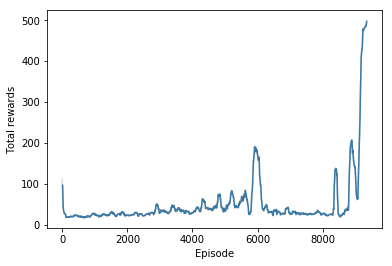

In [164]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

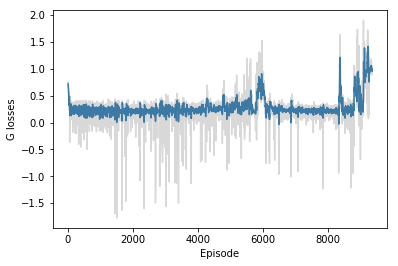

In [165]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

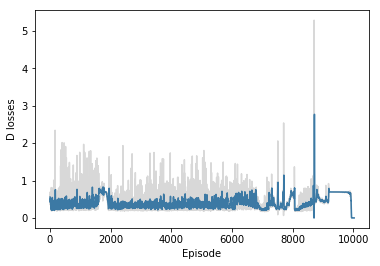

In [107]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [108]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        if total_reward == 500:
            break
                
# Closing the env
env.close()

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.